# MeOH synthesis model comparison (Grabow vs RMG)

Source for grabow model:  
Grabow, L. C., & Mavrikakis, M. (2011). Mechanism of methanol synthesis on cu through CO2 and CO hydrogenation. ACS Catalysis, 1(4), 365–384. https://doi.org/10.1021/cs200055d

In [1]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os
import sys
from IPython.display import Image

import itertools
import logging
from collections import defaultdict

import scipy.linalg as la

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.5.1


## Experimental Conditions for Graaf spinning basket reactor study.

Graaf, G. H., Stamhuis, E. J., & Beenackers, A. A. C. M. (1988). Kinetics of low-pressure methanol synthesis. Chemical Engineering Science, 43(12), 3185–3195. https://doi.org/10.1016/0009-2509(88)85127-3


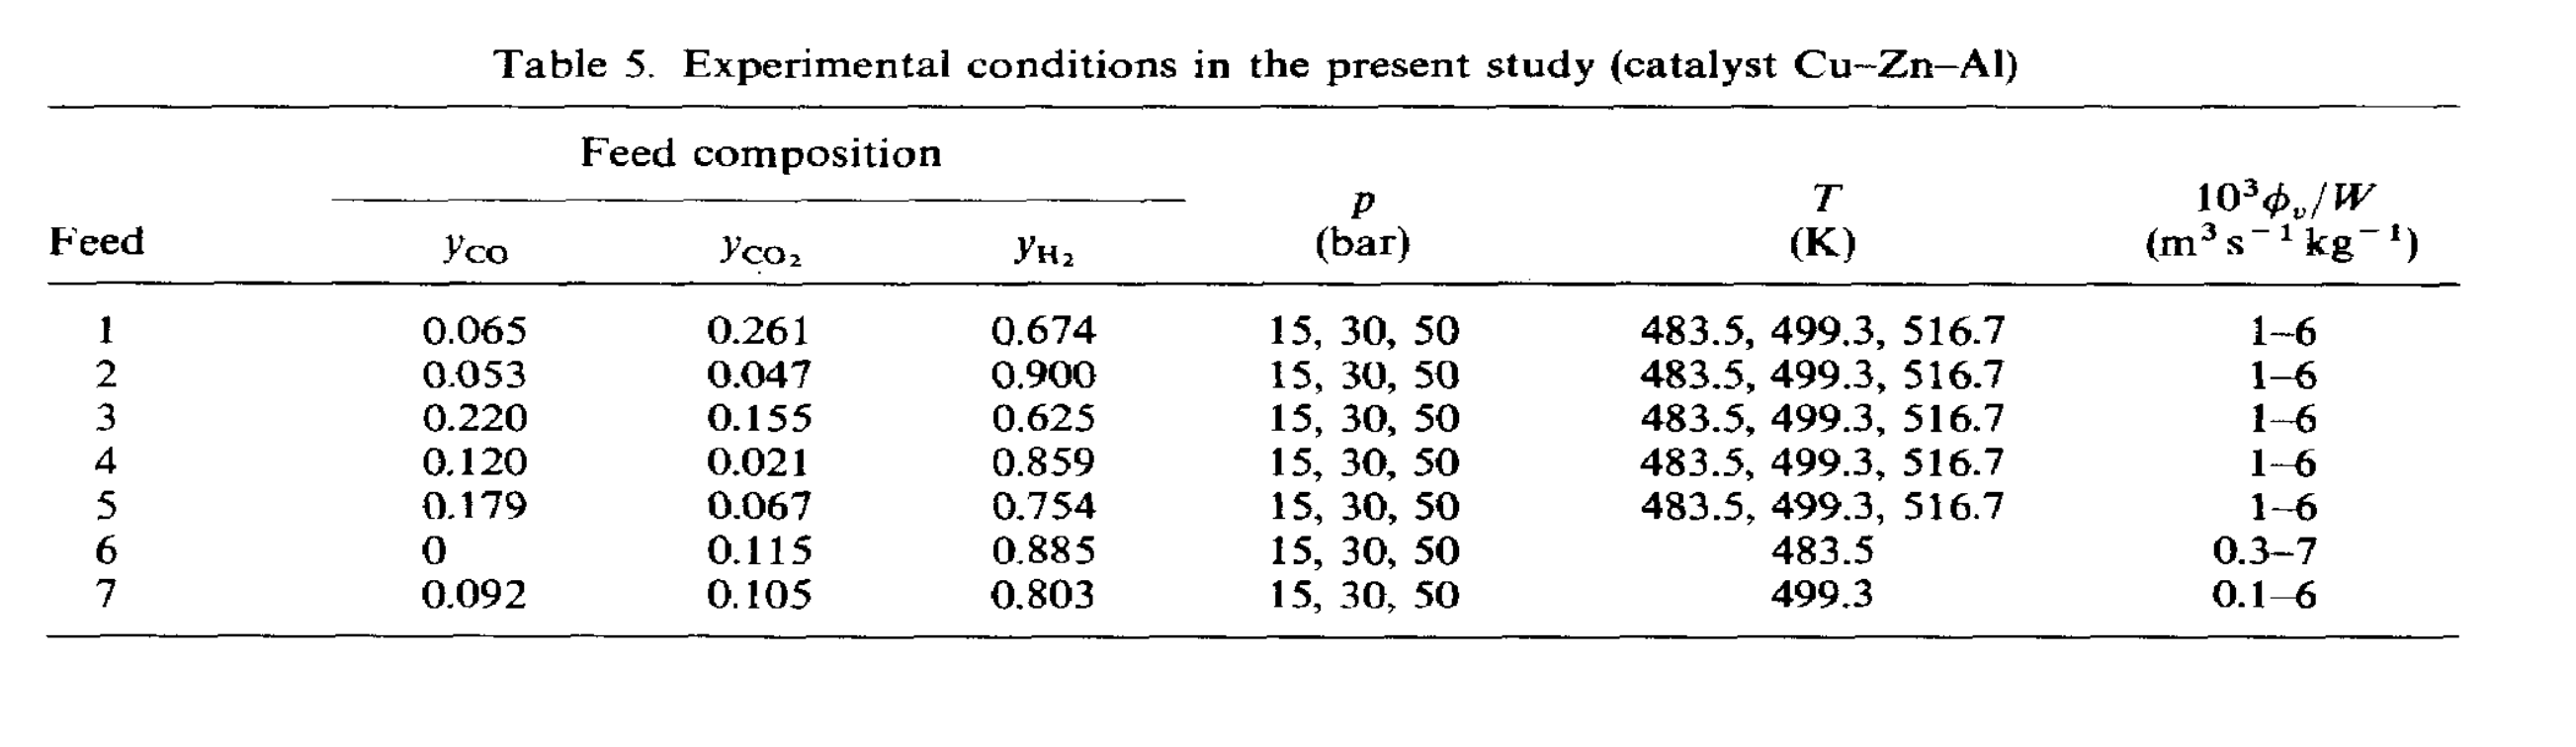

In [2]:

Image(filename='../images/Graaf_Experimental_Conditions.png',width = 700, height = 300) 

## Experimental Conditions for Graaf spinning basket reactor study (PhD thesis).

Graaf, Geert. (2016). The Synthesis of methanol in Gas-Solid and Gas-Slurry Reactors - PhD Thesis, 1988. 10.13140/RG.2.1.1002.8402. 


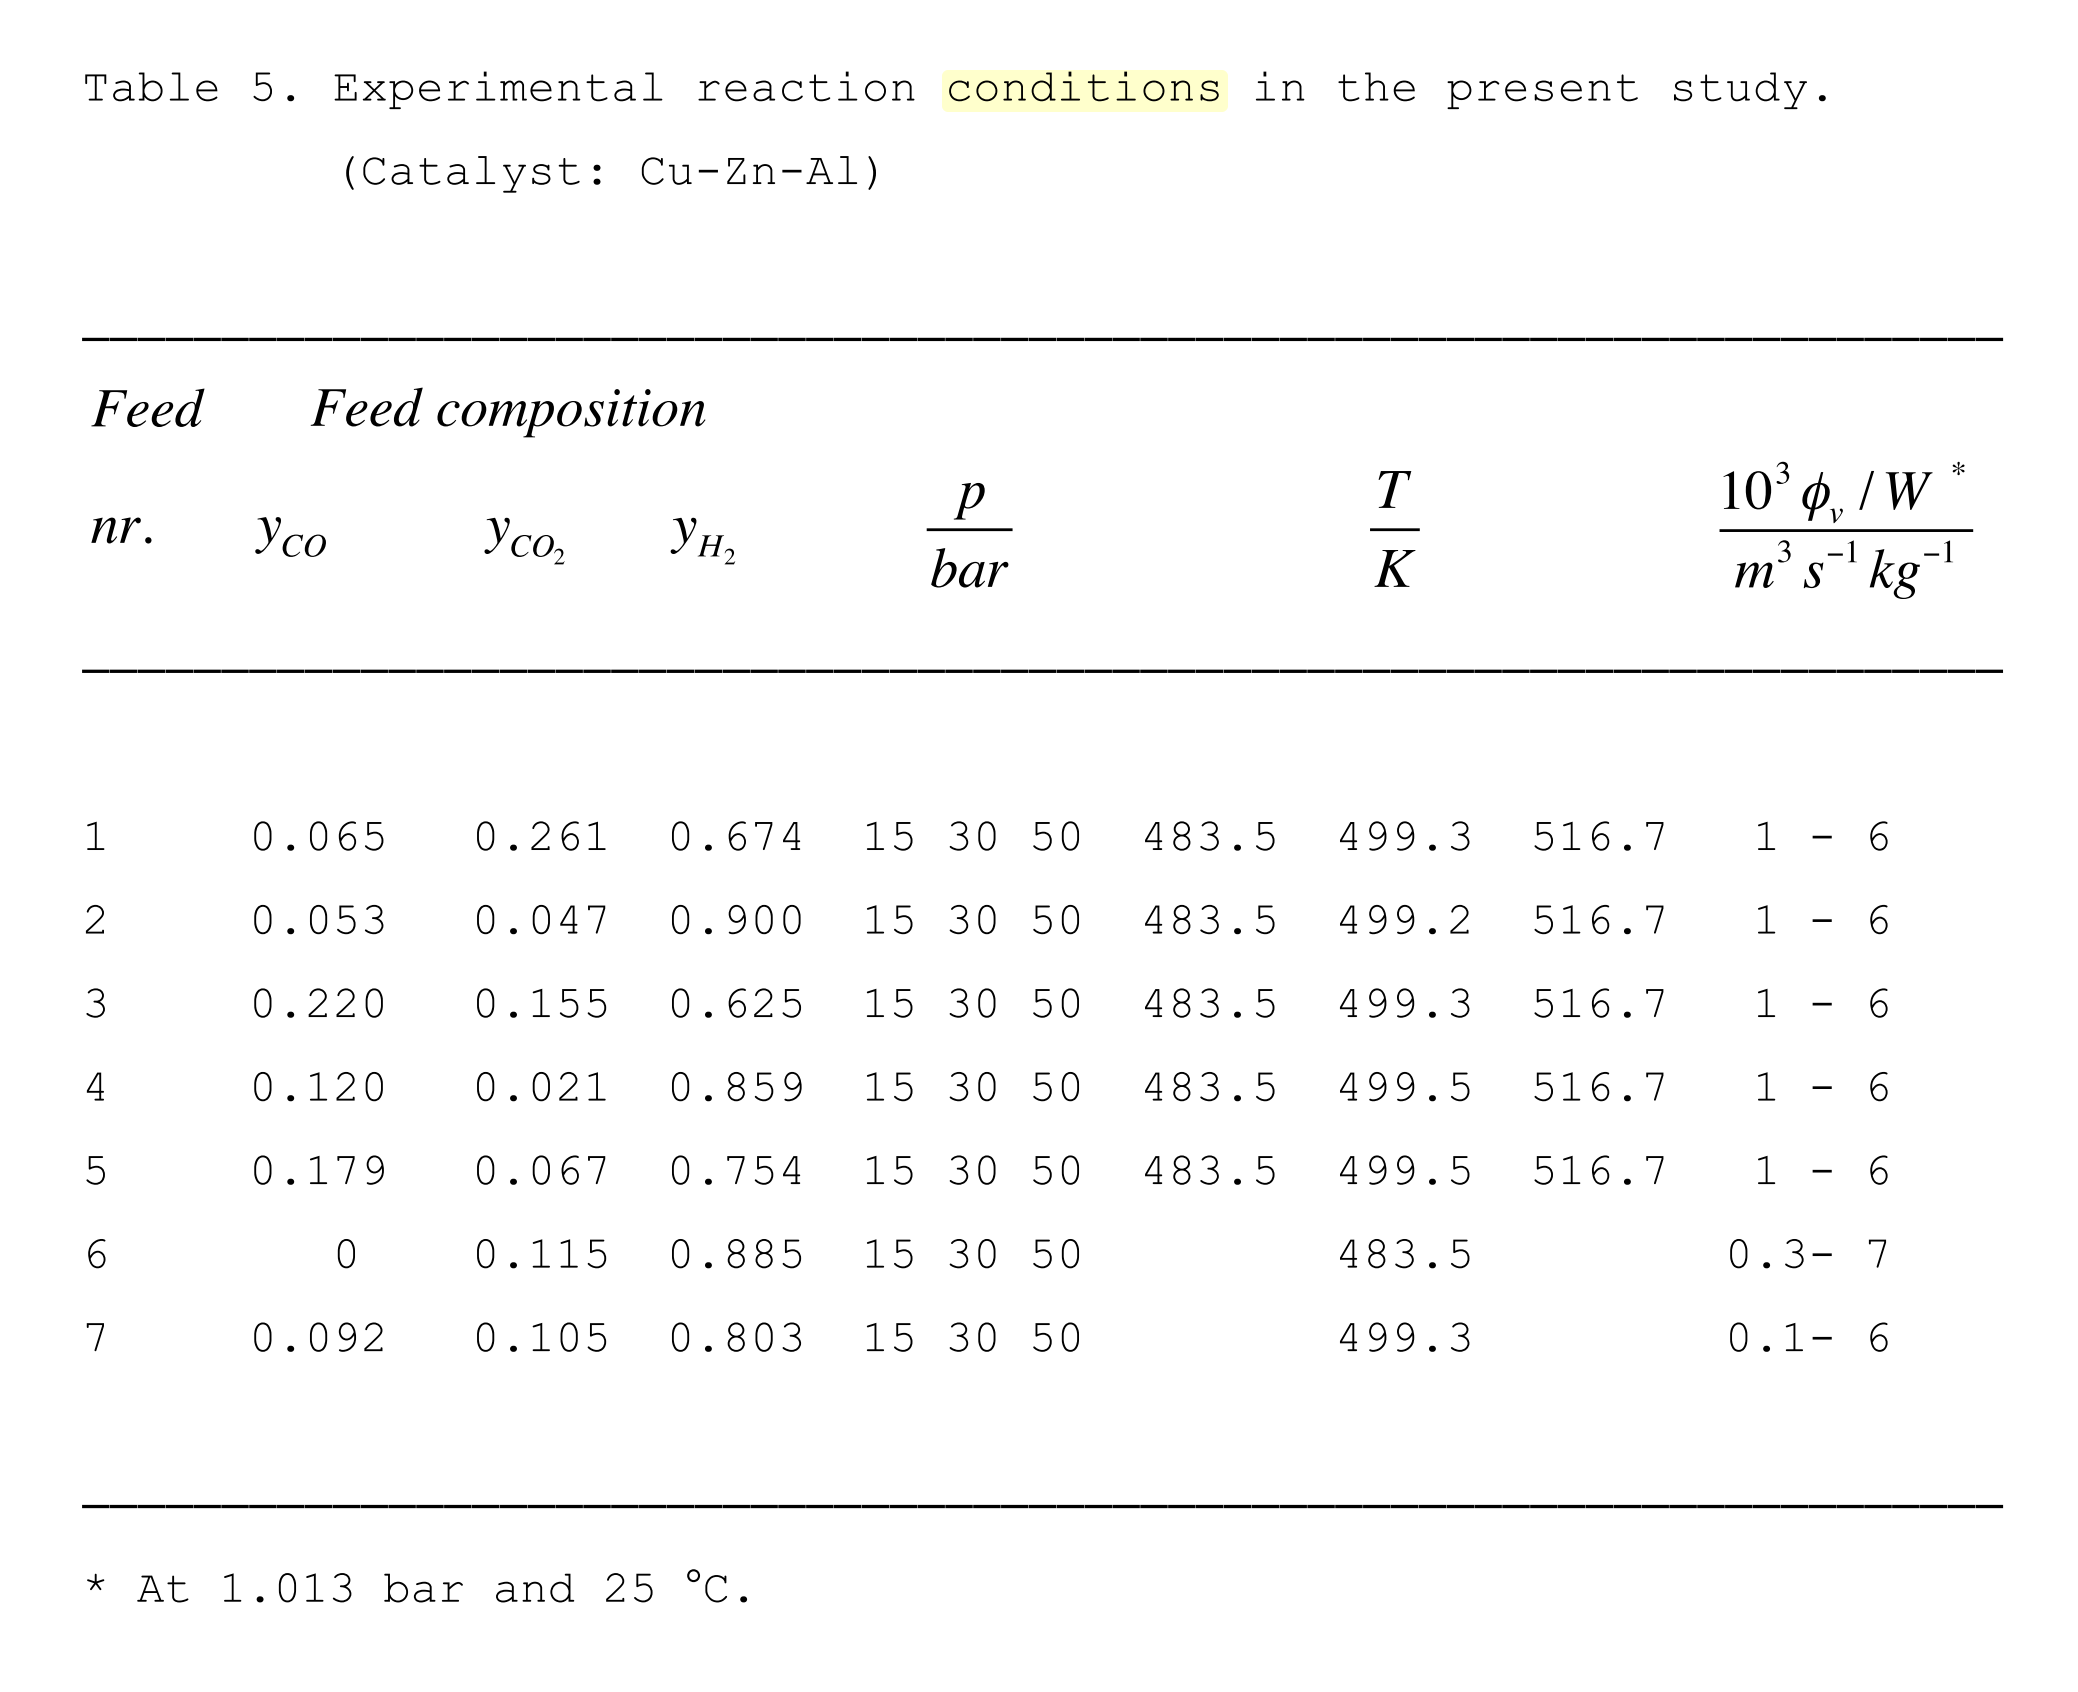

In [3]:

Image(filename='../images/Graaf_PhD_Experimental_Conditions.png',width = 600, height = 300) 

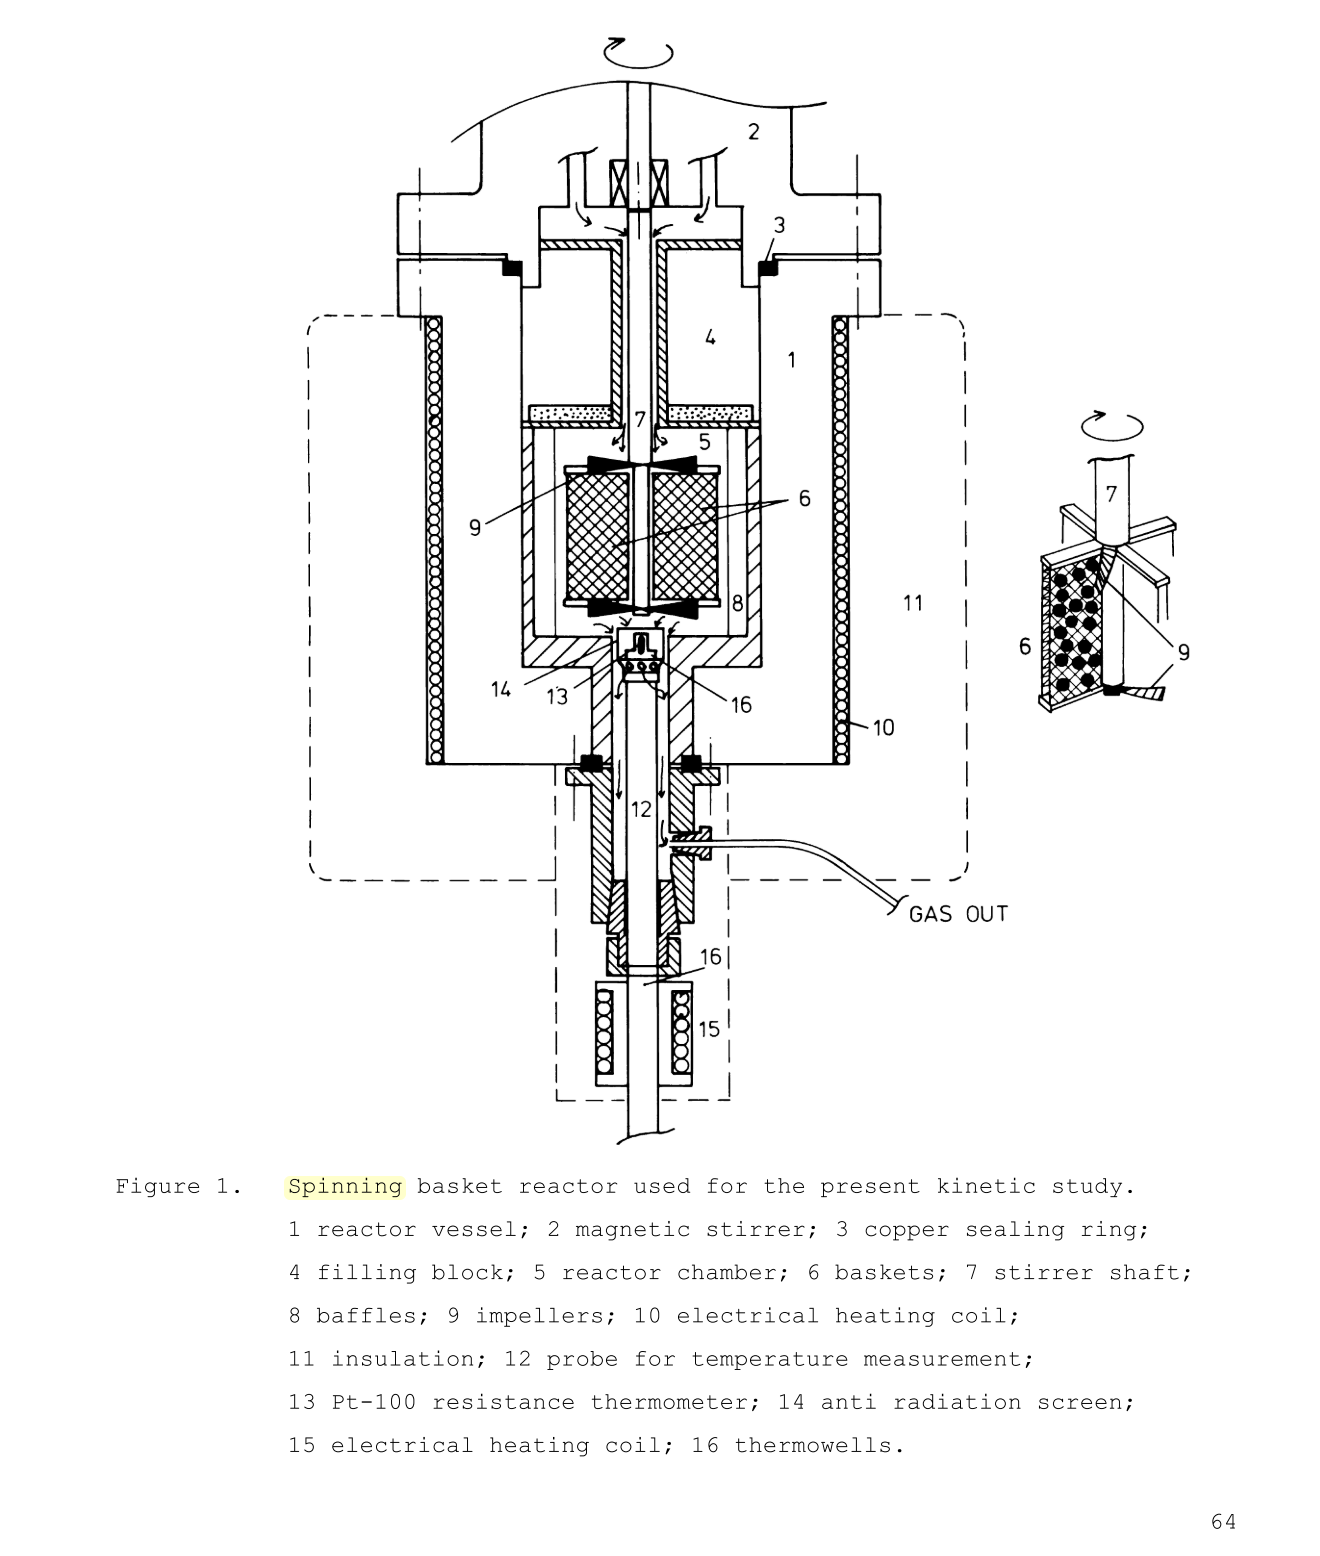

In [4]:
Image(filename='../images/spinning_basket_reactor_Graff.png')

## Graaf reactor specifications
pp 260-269: 2 Phase reactor Conditions
catalyst weights used: 4.24, 1.36, 7.97, 1.53 g catalyst used for their experiments

$\frac{10^{3}\phi_v}{W}$ volume flow rate at T=298.15K, P = 1.013 bar. per kg catalyst

pp 63 ID of reactor and height are 70mm each 

## Industrial conditions
temp =  230-280C.  
pressure = 50-120 atm.   
CO/CO2/H2 = 10/10/80.    

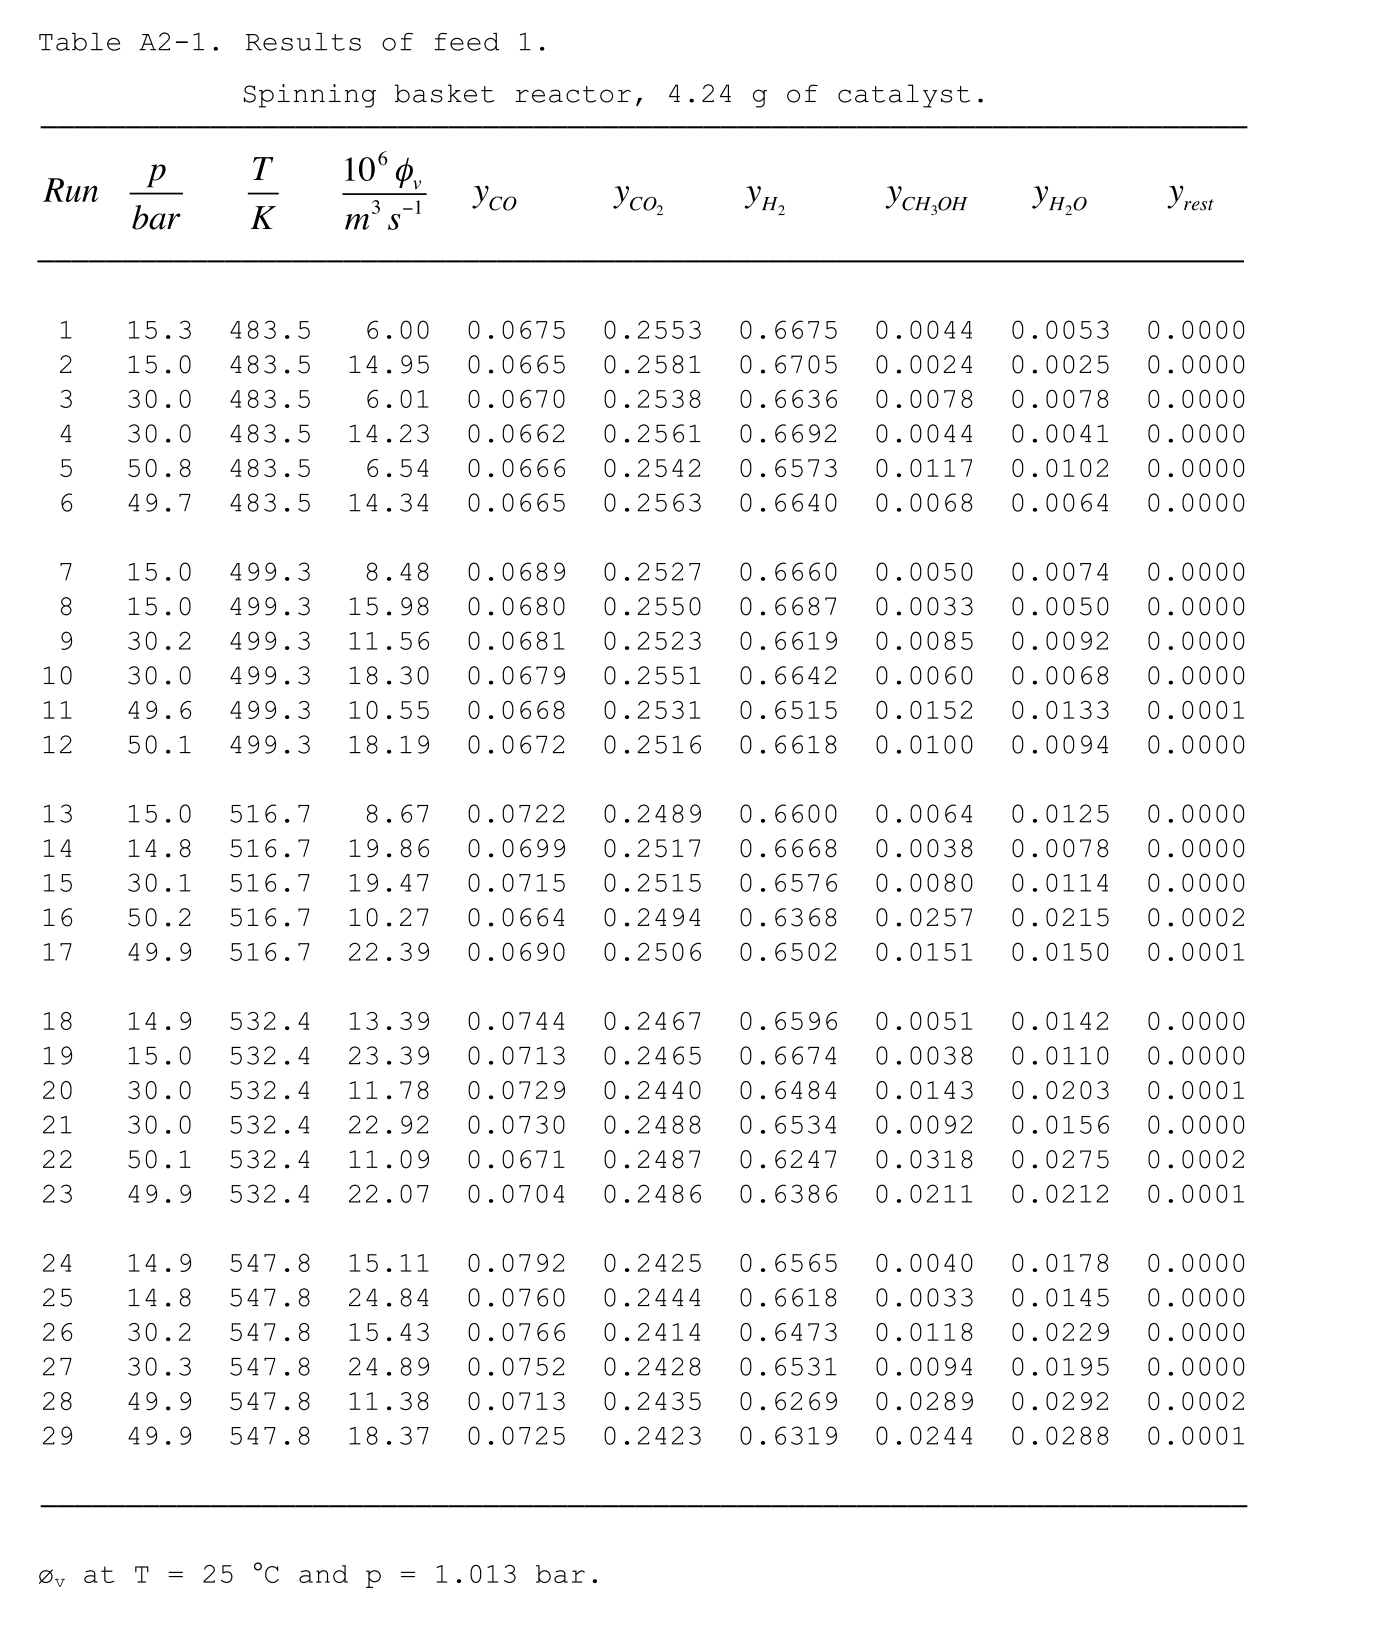

In [5]:
Image(filename='../images/Graaf_Feed_1.png',width = 600, height = 300) 

In [25]:
# os.remove("Results_single.csv") 
# Grabow model and RMG input files
# cti_file_rmg = 'Grabow_species_removed/chem_annotated_removed.cti'
cti_file_rmg = '/work/westgroup/ChrisB/meoh-synthesis_RMG/meOH-synthesis/base/cantera/chem_annotated.cti'

# Multipliers
cat_mult = 1

#constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15         # [kelvin]
temp = 400# 483.5                # [kelvin]
pressure = 15.3*1e5         # [Pascals] 
X_co = 0.025
X_co2= 0.025
X_h2 = 0.95
mw_co = 28.01e-3     # [kg/mol]
mw_co2 = 44.01e-3    # [kg/mol]
mw_h2 = 1.01e-3      # [kg/mol]

# CO/CO2/H2/H2O: typical is 
concentrations_rmg = {'CO(3)': X_co,'CO2(4)': X_co2, 'H2(2)':X_h2}

# initialize cantera gas and surface
gas= ct.Solution(cti_file_rmg,'gas')

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg,'surface1', [gas])

# gas_grab.TPX = 
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = {'X(1)':0.99,'O*(11)':0.01}

# create gas inlet
inlet = ct.Reservoir(gas)

#create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume
rradius = 35e-3
rlength = 70e-3
rvol = (rradius**2)*pi*rlength

# Catalyst Surface Area
site_density = surf.site_density*1000                #[mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_weight = 4.24e-3                                 #[kg]
cat_site_per_wt = (300*1e-6)*1000                    #[mol/kg] 1e-6mol/micromole, 1000g/kg
cat_area = cat_mult*site_density/(cat_weight*cat_site_per_wt) #[m^3]

# reactor initialization
# r = ct.IdealGasConstPressureReactor(gas, energy='off')
r = ct.IdealGasReactor(gas, energy='off')
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol

# flow controllers (Graaf measured flow at 293.15 and 1 atm)
one_atm = ct.one_atm
FC_temp = 293.15
volume_flow = 4.24e-3                                               # [m^3/s]
molar_flow = volume_flow*one_atm/(8.3145*FC_temp)                     # [mol/s]
mass_flow = molar_flow*(X_co*mw_co+X_co2*mw_co2) # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)
outlet_mfc = ct.PressureController(r, exhaust, master=mfc, K=0.01)


# initialize reactor network
sim = ct.ReactorNet([r])

print(cat_area,volume_flow, )

0.02313679245283019 0.00424


In [14]:
for i in range(0, surf.n_reactions):
     if 'C2HOX(465)' in str(surf.reaction_equation(i)):
        print(surf.reaction_equation(i), i)
#         surf.set_multiplier(0.1,i)
        
for i in range(0, surf.n_reactions):
     if 'H2X(51)' in str(surf.reaction_equation(i)):
        print(surf.reaction_equation(i), i)
#         surf.set_multiplier(0.0,i)
        


H2(2) + X(1) <=> H2X(51) 108
H2X(51) + O*(11) <=> H*(10) + OH*(12) 109
H2X(51) + OH*(12) <=> H*(10) + H2O*(13) 110
CO*(14) + H2X(51) <=> H*(10) + HCO*(16) 111
CO2*(15) + H2X(51) <=> H*(10) + HCOO*(17) 112
CO2*(15) + H2X(51) <=> COOH*(18) + H*(10) 113
H2X(51) + HCOO*(17) <=> H*(10) + HCOOH*(19) 114
COOH*(18) + H2X(51) <=> H*(10) + HCOOH*(19) 115
CH2O*(20) + H*(10) <=> H2X(51) + HCO*(16) 116
CH2O*(20) + H2X(51) <=> CH3O*(21) + H*(10) 117
H2X(51) + HCOOH*(19) <=> CH3O2*(22) + H*(10) 118
CH3O*(21) + H2X(51) <=> CH3OH*(23) + H*(10) 119
COXX(63) + H2X(51) <=> CHOX2(64) + H*(10) 134


## Grabow Values Given

300 $\mu$mol(sites)/g(catalyst).

In [ ]:
print("Time (s)   O*(11)")
t = 0.0
dt = 1e-12
print(f"{sim.time}   {surf['O*(11)'].X}")


while t < 200.0:
    t += dt
    sim.advance(t)
    print(f"{sim.time}   {surf['O*(11)'].X}")


Time (s)   O*(11)
0.0   [0.01]
1e-11   [0.00981118]
2e-11   [0.00955688]
3e-11   [0.00929789]
4e-11   [0.00904239]
4.9999999999999995e-11   [0.00877326]
6e-11   [0.00854044]
7e-11   [0.00830074]
8.000000000000001e-11   [0.00801634]
9.000000000000001e-11   [0.00781995]
1.0000000000000002e-10   [0.00755841]
1.1000000000000002e-10   [0.00734697]
1.2000000000000003e-10   [0.00710331]
1.3000000000000002e-10   [0.00684344]
1.4e-10   [0.00663884]
1.5e-10   [0.0064033]
1.6e-10   [0.00619886]
1.6999999999999998e-10   [0.00596706]
1.7999999999999997e-10   [0.00574364]
1.8999999999999996e-10   [0.00552467]
1.9999999999999996e-10   [0.00528035]
2.0999999999999995e-10   [0.00509788]
2.1999999999999994e-10   [0.00482644]
2.2999999999999993e-10   [0.00464698]
2.3999999999999995e-10   [0.00438005]
2.4999999999999996e-10   [0.00420362]
2.6e-10   [0.00402843]
2.7e-10   [0.00376801]
2.8e-10   [0.00359602]
2.9000000000000003e-10   [0.00342538]
3.0000000000000005e-10   [0.00317206]
3.1000000000000007e-10  

3.4700000000000234e-09   [5.42142367e-13]
3.4800000000000236e-09   [5.37762921e-13]
3.4900000000000237e-09   [5.41048858e-13]
3.500000000000024e-09   [5.35858794e-13]
3.510000000000024e-09   [5.35551348e-13]
3.5200000000000242e-09   [5.33042958e-13]
3.5300000000000244e-09   [5.313151e-13]
3.5400000000000246e-09   [5.31504546e-13]
3.5500000000000248e-09   [5.28754553e-13]
3.560000000000025e-09   [5.28754553e-13]
3.570000000000025e-09   [5.21767264e-13]
3.5800000000000253e-09   [5.21767264e-13]
3.5900000000000254e-09   [5.21767264e-13]
3.6000000000000256e-09   [5.33042508e-13]
3.6100000000000258e-09   [5.33042508e-13]
3.620000000000026e-09   [5.33042508e-13]
3.630000000000026e-09   [5.33042508e-13]
3.6400000000000263e-09   [5.17093076e-13]
3.6500000000000265e-09   [5.17093076e-13]
3.6600000000000267e-09   [5.17093076e-13]
3.670000000000027e-09   [5.11952498e-13]
3.680000000000027e-09   [5.11952498e-13]
3.690000000000027e-09   [5.11952498e-13]
3.7000000000000273e-09   [5.11952498e-13]
3.7

8.669999999999908e-09   [1.70141397e-13]
8.679999999999908e-09   [1.70141397e-13]
8.689999999999908e-09   [1.70141397e-13]
8.699999999999908e-09   [1.70141397e-13]
8.709999999999907e-09   [1.70141397e-13]
8.719999999999907e-09   [2.05989186e-13]
8.729999999999907e-09   [2.05989186e-13]
8.739999999999907e-09   [2.05989186e-13]
8.749999999999906e-09   [2.05989186e-13]
8.759999999999906e-09   [2.05989186e-13]
8.769999999999906e-09   [2.05989186e-13]
8.779999999999906e-09   [2.05989186e-13]
8.789999999999905e-09   [2.05989186e-13]
8.799999999999905e-09   [2.05989186e-13]
8.809999999999905e-09   [1.44829891e-13]
8.819999999999905e-09   [1.44829891e-13]
8.829999999999904e-09   [1.44829891e-13]
8.839999999999904e-09   [1.44829891e-13]
8.849999999999904e-09   [1.44829891e-13]
8.859999999999904e-09   [1.44829891e-13]
8.869999999999903e-09   [1.44829891e-13]
8.879999999999903e-09   [1.44829891e-13]
8.889999999999903e-09   [1.44829891e-13]
8.899999999999903e-09   [1.44829891e-13]
8.90999999999990

1.4059999999999778e-08   [1.06580989e-13]
1.4069999999999778e-08   [1.06580989e-13]
1.4079999999999778e-08   [1.06580989e-13]
1.4089999999999777e-08   [1.06580989e-13]
1.4099999999999777e-08   [1.06580989e-13]
1.4109999999999777e-08   [1.06580989e-13]
1.4119999999999777e-08   [1.06580989e-13]
1.4129999999999776e-08   [1.06580989e-13]
1.4139999999999776e-08   [1.06580989e-13]
1.4149999999999776e-08   [1.06580989e-13]
1.4159999999999776e-08   [1.06580989e-13]
1.4169999999999775e-08   [1.06580989e-13]
1.4179999999999775e-08   [1.06580989e-13]
1.4189999999999775e-08   [1.06580989e-13]
1.4199999999999775e-08   [1.06580989e-13]
1.4209999999999775e-08   [1.06580989e-13]
1.4219999999999774e-08   [1.01438794e-13]
1.4229999999999774e-08   [1.01438794e-13]
1.4239999999999774e-08   [1.01438794e-13]
1.4249999999999774e-08   [1.01438794e-13]
1.4259999999999773e-08   [1.01438794e-13]
1.4269999999999773e-08   [1.01438794e-13]
1.4279999999999773e-08   [1.01438794e-13]
1.4289999999999773e-08   [1.014387

1.9790000000000447e-08   [7.55668386e-14]
1.980000000000045e-08   [7.55668386e-14]
1.981000000000045e-08   [7.55668386e-14]
1.982000000000045e-08   [7.55668386e-14]
1.9830000000000453e-08   [7.55668386e-14]
1.9840000000000454e-08   [7.55668386e-14]
1.9850000000000456e-08   [7.55668386e-14]
1.9860000000000457e-08   [7.55668386e-14]
1.987000000000046e-08   [7.55668386e-14]
1.988000000000046e-08   [7.55668386e-14]
1.989000000000046e-08   [7.55668386e-14]
1.9900000000000463e-08   [7.55668386e-14]
1.9910000000000464e-08   [7.55668386e-14]
1.9920000000000466e-08   [7.55668386e-14]
1.9930000000000467e-08   [7.55668386e-14]
1.994000000000047e-08   [7.55668386e-14]
1.995000000000047e-08   [8.18193025e-14]
1.996000000000047e-08   [8.18193025e-14]
1.9970000000000473e-08   [8.18193025e-14]
1.9980000000000474e-08   [8.18193025e-14]
1.9990000000000475e-08   [8.18193025e-14]
2.0000000000000477e-08   [8.18193025e-14]
2.0010000000000478e-08   [8.18193025e-14]
2.002000000000048e-08   [8.18193025e-14]
2.

2.7060000000001474e-08   [4.39217392e-14]
2.7070000000001476e-08   [4.39217392e-14]
2.7080000000001477e-08   [4.39217392e-14]
2.709000000000148e-08   [4.39217392e-14]
2.710000000000148e-08   [4.39217392e-14]
2.711000000000148e-08   [4.28011078e-14]
2.7120000000001483e-08   [4.28011078e-14]
2.7130000000001484e-08   [4.28011078e-14]
2.7140000000001486e-08   [4.28011078e-14]
2.7150000000001487e-08   [4.28011078e-14]
2.716000000000149e-08   [4.28011078e-14]
2.717000000000149e-08   [4.28011078e-14]
2.718000000000149e-08   [4.28011078e-14]
2.7190000000001493e-08   [4.28011078e-14]
2.7200000000001494e-08   [4.28011078e-14]
2.7210000000001496e-08   [4.28011078e-14]
2.7220000000001497e-08   [4.28011078e-14]
2.72300000000015e-08   [4.28011078e-14]
2.72400000000015e-08   [4.28011078e-14]
2.72500000000015e-08   [4.28011078e-14]
2.7260000000001503e-08   [4.28011078e-14]
2.7270000000001504e-08   [4.28011078e-14]
2.7280000000001506e-08   [4.28011078e-14]
2.7290000000001507e-08   [4.28011078e-14]
2.73

3.456000000000096e-08   [2.21205466e-14]
3.457000000000096e-08   [2.21205466e-14]
3.4580000000000956e-08   [2.21205466e-14]
3.4590000000000954e-08   [2.21205466e-14]
3.460000000000095e-08   [2.21205466e-14]
3.461000000000095e-08   [2.21205466e-14]
3.462000000000095e-08   [2.21205466e-14]
3.4630000000000946e-08   [2.21205466e-14]
3.4640000000000944e-08   [2.21205466e-14]
3.465000000000094e-08   [2.21205466e-14]
3.466000000000094e-08   [2.21205466e-14]
3.467000000000094e-08   [2.21205466e-14]
3.4680000000000937e-08   [2.21205466e-14]
3.4690000000000935e-08   [2.21205466e-14]
3.470000000000093e-08   [2.21205466e-14]
3.471000000000093e-08   [2.21205466e-14]
3.472000000000093e-08   [2.21205466e-14]
3.473000000000093e-08   [2.21205466e-14]
3.4740000000000925e-08   [2.21205466e-14]
3.475000000000092e-08   [2.21205466e-14]
3.476000000000092e-08   [2.21205466e-14]
3.477000000000092e-08   [2.21205466e-14]
3.478000000000092e-08   [2.21205466e-14]
3.4790000000000916e-08   [2.21205466e-14]
3.480000

4.2019999999999545e-08   [4.56295844e-14]
4.202999999999954e-08   [4.56295844e-14]
4.203999999999954e-08   [4.56295844e-14]
4.204999999999954e-08   [4.56295844e-14]
4.205999999999954e-08   [4.56295844e-14]
4.2069999999999536e-08   [4.56295844e-14]
4.2079999999999534e-08   [4.56295844e-14]
4.208999999999953e-08   [4.56295844e-14]
4.209999999999953e-08   [4.56295844e-14]
4.210999999999953e-08   [4.56295844e-14]
4.2119999999999526e-08   [4.56295844e-14]
4.2129999999999524e-08   [4.56295844e-14]
4.213999999999952e-08   [4.56295844e-14]
4.214999999999952e-08   [4.56295844e-14]
4.215999999999952e-08   [4.56295844e-14]
4.2169999999999517e-08   [4.56295844e-14]
4.2179999999999515e-08   [4.56295844e-14]
4.218999999999951e-08   [4.56295844e-14]
4.219999999999951e-08   [4.56295844e-14]
4.220999999999951e-08   [4.56295844e-14]
4.221999999999951e-08   [4.56295844e-14]
4.2229999999999505e-08   [4.56295844e-14]
4.2239999999999503e-08   [4.56295844e-14]
4.22499999999995e-08   [4.56295844e-14]
4.225999

4.947999999999813e-08   [2.0832944e-14]
4.948999999999813e-08   [2.0832944e-14]
4.949999999999813e-08   [2.0832944e-14]
4.9509999999998125e-08   [2.0832944e-14]
4.9519999999998123e-08   [2.0832944e-14]
4.952999999999812e-08   [2.0832944e-14]
4.953999999999812e-08   [2.0832944e-14]
4.954999999999812e-08   [2.0832944e-14]
4.9559999999998116e-08   [2.0832944e-14]
4.9569999999998114e-08   [2.0832944e-14]
4.957999999999811e-08   [2.0832944e-14]
4.958999999999811e-08   [2.0832944e-14]
4.959999999999811e-08   [2.0832944e-14]
4.9609999999998106e-08   [2.0832944e-14]
4.9619999999998104e-08   [1.59542947e-14]
4.96299999999981e-08   [1.59542947e-14]
4.96399999999981e-08   [1.59542947e-14]
4.96499999999981e-08   [1.59542947e-14]
4.96599999999981e-08   [1.59542947e-14]
4.9669999999998095e-08   [1.59542947e-14]
4.967999999999809e-08   [1.59542947e-14]
4.968999999999809e-08   [1.59542947e-14]
4.969999999999809e-08   [1.59542947e-14]
4.970999999999809e-08   [1.59542947e-14]
4.9719999999998085e-08   [1

5.691999999999672e-08   [4.73625731e-15]
5.692999999999672e-08   [4.73625731e-15]
5.693999999999672e-08   [4.73625731e-15]
5.6949999999996715e-08   [4.73625731e-15]
5.695999999999671e-08   [4.73625731e-15]
5.696999999999671e-08   [4.73625731e-15]
5.697999999999671e-08   [4.73625731e-15]
5.698999999999671e-08   [4.73625731e-15]
5.6999999999996705e-08   [4.73625731e-15]
5.7009999999996703e-08   [4.73625731e-15]
5.70199999999967e-08   [4.73625731e-15]
5.70299999999967e-08   [4.73625731e-15]
5.70399999999967e-08   [4.73625731e-15]
5.7049999999996696e-08   [4.73625731e-15]
5.7059999999996694e-08   [4.73625731e-15]
5.706999999999669e-08   [4.73625731e-15]
5.707999999999669e-08   [4.73625731e-15]
5.708999999999669e-08   [1.02591796e-14]
5.7099999999996686e-08   [1.02591796e-14]
5.7109999999996685e-08   [1.02591796e-14]
5.711999999999668e-08   [1.02591796e-14]
5.712999999999668e-08   [1.02591796e-14]
5.713999999999668e-08   [1.02591796e-14]
5.714999999999668e-08   [1.02591796e-14]
5.7159999999

6.431999999999532e-08   [1.17666969e-14]
6.432999999999532e-08   [1.17666969e-14]
6.433999999999532e-08   [1.17666969e-14]
6.434999999999532e-08   [1.17666969e-14]
6.435999999999532e-08   [1.17666969e-14]
6.436999999999531e-08   [1.17666969e-14]
6.437999999999531e-08   [1.17666969e-14]
6.438999999999531e-08   [1.17666969e-14]
6.439999999999531e-08   [1.17666969e-14]
6.440999999999531e-08   [1.17666969e-14]
6.44199999999953e-08   [1.17666969e-14]
6.44299999999953e-08   [1.17666969e-14]
6.44399999999953e-08   [1.17666969e-14]
6.44499999999953e-08   [1.17666969e-14]
6.44599999999953e-08   [1.17666969e-14]
6.44699999999953e-08   [1.17666969e-14]
6.44799999999953e-08   [1.17666969e-14]
6.448999999999529e-08   [1.17666969e-14]
6.449999999999529e-08   [1.17666969e-14]
6.450999999999529e-08   [1.17666969e-14]
6.451999999999529e-08   [1.17666969e-14]
6.452999999999528e-08   [1.17666969e-14]
6.453999999999528e-08   [1.17666969e-14]
6.454999999999528e-08   [1.17666969e-14]
6.455999999999528e-08  

7.176999999999391e-08   [1.08749054e-14]
7.177999999999391e-08   [1.08749054e-14]
7.178999999999391e-08   [1.08749054e-14]
7.17999999999939e-08   [1.08749054e-14]
7.18099999999939e-08   [1.08749054e-14]
7.18199999999939e-08   [1.08749054e-14]
7.18299999999939e-08   [1.08749054e-14]
7.18399999999939e-08   [1.08749054e-14]
7.18499999999939e-08   [1.08749054e-14]
7.18599999999939e-08   [1.08749054e-14]
7.186999999999389e-08   [1.08749054e-14]
7.187999999999389e-08   [1.08749054e-14]
7.188999999999389e-08   [1.08749054e-14]
7.189999999999389e-08   [1.08749054e-14]
7.190999999999389e-08   [1.08749054e-14]
7.191999999999388e-08   [1.08749054e-14]
7.192999999999388e-08   [1.08749054e-14]
7.193999999999388e-08   [1.08749054e-14]
7.194999999999388e-08   [1.08749054e-14]
7.195999999999388e-08   [1.08749054e-14]
7.196999999999387e-08   [1.08749054e-14]
7.197999999999387e-08   [1.08749054e-14]
7.198999999999387e-08   [1.08749054e-14]
7.199999999999387e-08   [1.08749054e-14]
7.200999999999387e-08  

7.926999999999249e-08   [-7.45610502e-16]
7.927999999999249e-08   [-7.45610502e-16]
7.928999999999249e-08   [-7.45610502e-16]
7.929999999999248e-08   [-7.45610502e-16]
7.930999999999248e-08   [-7.45610502e-16]
7.931999999999248e-08   [-7.45610502e-16]
7.932999999999248e-08   [-7.45610502e-16]
7.933999999999248e-08   [-7.45610502e-16]
7.934999999999248e-08   [-7.45610502e-16]
7.935999999999247e-08   [-7.45610502e-16]
7.936999999999247e-08   [-7.45610502e-16]
7.937999999999247e-08   [-7.45610502e-16]
7.938999999999247e-08   [-7.45610502e-16]
7.939999999999247e-08   [2.95469367e-14]
7.940999999999246e-08   [2.95469367e-14]
7.941999999999246e-08   [2.95469367e-14]
7.942999999999246e-08   [2.95469367e-14]
7.943999999999246e-08   [2.95469367e-14]
7.944999999999246e-08   [2.95469367e-14]
7.945999999999245e-08   [2.95469367e-14]
7.946999999999245e-08   [2.95469367e-14]
7.947999999999245e-08   [2.95469367e-14]
7.948999999999245e-08   [2.95469367e-14]
7.949999999999245e-08   [2.95469367e-14]
7.9

8.673999999999107e-08   [-4.94637398e-15]
8.674999999999107e-08   [-4.94637398e-15]
8.675999999999107e-08   [-4.94637398e-15]
8.676999999999107e-08   [-2.17742849e-14]
8.677999999999107e-08   [-2.17742849e-14]
8.678999999999106e-08   [-2.17742849e-14]
8.679999999999106e-08   [-2.17742849e-14]
8.680999999999106e-08   [-2.17742849e-14]
8.681999999999106e-08   [-2.17742849e-14]
8.682999999999106e-08   [-2.17742849e-14]
8.683999999999106e-08   [-2.17742849e-14]
8.684999999999105e-08   [-2.17742849e-14]
8.685999999999105e-08   [-2.17742849e-14]
8.686999999999105e-08   [-2.17742849e-14]
8.687999999999105e-08   [-2.17742849e-14]
8.688999999999105e-08   [-2.17742849e-14]
8.689999999999104e-08   [-2.17742849e-14]
8.690999999999104e-08   [-2.17742849e-14]
8.691999999999104e-08   [-2.17742849e-14]
8.692999999999104e-08   [-2.17742849e-14]
8.693999999999104e-08   [-2.17742849e-14]
8.694999999999103e-08   [-2.17742849e-14]
8.695999999999103e-08   [-2.17742849e-14]
8.696999999999103e-08   [-2.177428

9.408999999998968e-08   [6.76629295e-15]
9.409999999998968e-08   [6.76629295e-15]
9.410999999998968e-08   [6.76629295e-15]
9.411999999998968e-08   [6.76629295e-15]
9.412999999998967e-08   [6.76629295e-15]
9.413999999998967e-08   [6.76629295e-15]
9.414999999998967e-08   [6.76629295e-15]
9.415999999998967e-08   [6.76629295e-15]
9.416999999998967e-08   [6.76629295e-15]
9.417999999998966e-08   [6.76629295e-15]
9.418999999998966e-08   [6.76629295e-15]
9.419999999998966e-08   [6.76629295e-15]
9.420999999998966e-08   [6.76629295e-15]
9.421999999998966e-08   [6.76629295e-15]
9.422999999998965e-08   [6.76629295e-15]
9.423999999998965e-08   [6.76629295e-15]
9.424999999998965e-08   [6.76629295e-15]
9.425999999998965e-08   [6.76629295e-15]
9.426999999998965e-08   [6.76629295e-15]
9.427999999998964e-08   [6.76629295e-15]
9.428999999998964e-08   [6.76629295e-15]
9.429999999998964e-08   [6.76629295e-15]
9.430999999998964e-08   [6.76629295e-15]
9.431999999998964e-08   [6.76629295e-15]
9.43299999999896

1.0160999999998826e-07   [6.12434876e-15]
1.0161999999998825e-07   [6.12434876e-15]
1.0162999999998825e-07   [6.12434876e-15]
1.0163999999998825e-07   [6.12434876e-15]
1.0164999999998825e-07   [6.12434876e-15]
1.0165999999998825e-07   [6.12434876e-15]
1.0166999999998824e-07   [6.12434876e-15]
1.0167999999998824e-07   [6.12434876e-15]
1.0168999999998824e-07   [6.12434876e-15]
1.0169999999998824e-07   [6.12434876e-15]
1.0170999999998824e-07   [6.12434876e-15]
1.0171999999998823e-07   [6.12434876e-15]
1.0172999999998823e-07   [6.12434876e-15]
1.0173999999998823e-07   [6.12434876e-15]
1.0174999999998823e-07   [6.12434876e-15]
1.0175999999998823e-07   [6.12434876e-15]
1.0176999999998822e-07   [6.12434876e-15]
1.0177999999998822e-07   [6.12434876e-15]
1.0178999999998822e-07   [6.12434876e-15]
1.0179999999998822e-07   [6.12434876e-15]
1.0180999999998822e-07   [6.12434876e-15]
1.0181999999998822e-07   [6.12434876e-15]
1.0182999999998821e-07   [6.12434876e-15]
1.0183999999998821e-07   [6.124348

1.0912999999998683e-07   [5.60052507e-15]
1.0913999999998683e-07   [5.60052507e-15]
1.0914999999998683e-07   [5.60052507e-15]
1.0915999999998682e-07   [5.60052507e-15]
1.0916999999998682e-07   [5.60052507e-15]
1.0917999999998682e-07   [5.60052507e-15]
1.0918999999998682e-07   [5.60052507e-15]
1.0919999999998682e-07   [5.60052507e-15]
1.0920999999998681e-07   [5.60052507e-15]
1.0921999999998681e-07   [5.60052507e-15]
1.0922999999998681e-07   [5.60052507e-15]
1.0923999999998681e-07   [5.60052507e-15]
1.0924999999998681e-07   [5.60052507e-15]
1.092599999999868e-07   [5.60052507e-15]
1.092699999999868e-07   [5.60052507e-15]
1.092799999999868e-07   [5.60052507e-15]
1.092899999999868e-07   [5.60052507e-15]
1.092999999999868e-07   [5.60052507e-15]
1.093099999999868e-07   [5.60052507e-15]
1.093199999999868e-07   [5.60052507e-15]
1.0932999999998679e-07   [5.60052507e-15]
1.0933999999998679e-07   [5.60052507e-15]
1.0934999999998679e-07   [5.60052507e-15]
1.0935999999998679e-07   [5.60052507e-15]

1.166599999999854e-07   [5.17811922e-15]
1.166699999999854e-07   [5.17811922e-15]
1.166799999999854e-07   [5.17811922e-15]
1.166899999999854e-07   [5.17811922e-15]
1.166999999999854e-07   [5.17811922e-15]
1.1670999999998539e-07   [5.17811922e-15]
1.1671999999998539e-07   [5.17811922e-15]
1.1672999999998539e-07   [5.17811922e-15]
1.1673999999998539e-07   [5.17811922e-15]
1.1674999999998539e-07   [5.17811922e-15]
1.1675999999998538e-07   [5.17811922e-15]
1.1676999999998538e-07   [5.17811922e-15]
1.1677999999998538e-07   [5.17811922e-15]
1.1678999999998538e-07   [5.17811922e-15]
1.1679999999998538e-07   [5.17811922e-15]
1.1680999999998537e-07   [5.17811922e-15]
1.1681999999998537e-07   [5.17811922e-15]
1.1682999999998537e-07   [5.17811922e-15]
1.1683999999998537e-07   [5.17811922e-15]
1.1684999999998537e-07   [5.17811922e-15]
1.1685999999998536e-07   [5.17811922e-15]
1.1686999999998536e-07   [5.17811922e-15]
1.1687999999998536e-07   [5.17811922e-15]
1.1688999999998536e-07   [5.17811922e-1

1.242099999999906e-07   [4.98759119e-15]
1.242199999999906e-07   [4.98759119e-15]
1.2422999999999062e-07   [4.98759119e-15]
1.2423999999999064e-07   [4.98759119e-15]
1.2424999999999065e-07   [4.98759119e-15]
1.2425999999999066e-07   [4.98759119e-15]
1.2426999999999067e-07   [4.98759119e-15]
1.2427999999999068e-07   [4.98759119e-15]
1.242899999999907e-07   [4.98759119e-15]
1.242999999999907e-07   [4.98759119e-15]
1.2430999999999072e-07   [4.98759119e-15]
1.2431999999999073e-07   [4.98759119e-15]
1.2432999999999074e-07   [4.98759119e-15]
1.2433999999999075e-07   [4.98759119e-15]
1.2434999999999076e-07   [4.98759119e-15]
1.2435999999999077e-07   [4.98759119e-15]
1.2436999999999078e-07   [4.98759119e-15]
1.243799999999908e-07   [4.98759119e-15]
1.243899999999908e-07   [4.98759119e-15]
1.2439999999999082e-07   [4.98759119e-15]
1.2440999999999083e-07   [4.98759119e-15]
1.2441999999999084e-07   [4.98759119e-15]
1.2442999999999085e-07   [4.98759119e-15]
1.2443999999999086e-07   [4.98759119e-15

1.3173999999999914e-07   [7.05437232e-15]
1.3174999999999915e-07   [-7.11704361e-16]
1.3175999999999916e-07   [-7.11704361e-16]
1.3176999999999917e-07   [-7.11704361e-16]
1.3177999999999919e-07   [-7.11704361e-16]
1.317899999999992e-07   [-7.11704361e-16]
1.317999999999992e-07   [-7.11704361e-16]
1.3180999999999922e-07   [-7.11704361e-16]
1.3181999999999923e-07   [-7.11704361e-16]
1.3182999999999924e-07   [-7.11704361e-16]
1.3183999999999925e-07   [-7.11704361e-16]
1.3184999999999926e-07   [-7.11704361e-16]
1.3185999999999928e-07   [-7.11704361e-16]
1.318699999999993e-07   [-7.11704361e-16]
1.318799999999993e-07   [-7.11704361e-16]
1.318899999999993e-07   [-7.11704361e-16]
1.3189999999999932e-07   [-7.11704361e-16]
1.3190999999999933e-07   [-7.11704361e-16]
1.3191999999999934e-07   [-7.11704361e-16]
1.3192999999999936e-07   [-7.11704361e-16]
1.3193999999999937e-07   [-7.11704361e-16]
1.3194999999999938e-07   [-7.11704361e-16]
1.319599999999994e-07   [-7.11704361e-16]
1.319699999999994e

1.3923000000000763e-07   [-5.25772897e-14]
1.3924000000000764e-07   [-5.25772897e-14]
1.3925000000000766e-07   [-5.25772897e-14]
1.3926000000000767e-07   [-5.25772897e-14]
1.3927000000000768e-07   [-5.25772897e-14]
1.392800000000077e-07   [-5.25772897e-14]
1.392900000000077e-07   [-5.25772897e-14]
1.393000000000077e-07   [-5.25772897e-14]
1.3931000000000772e-07   [-5.25772897e-14]
1.3932000000000774e-07   [-5.25772897e-14]
1.3933000000000775e-07   [-5.25772897e-14]
1.3934000000000776e-07   [-5.25772897e-14]
1.3935000000000777e-07   [-5.25772897e-14]
1.3936000000000778e-07   [-5.25772897e-14]
1.393700000000078e-07   [-5.25772897e-14]
1.393800000000078e-07   [-5.25772897e-14]
1.3939000000000781e-07   [-5.25772897e-14]
1.3940000000000783e-07   [-5.25772897e-14]
1.3941000000000784e-07   [-5.25772897e-14]
1.3942000000000785e-07   [-5.25772897e-14]
1.3943000000000786e-07   [-5.25772897e-14]
1.3944000000000787e-07   [-5.25772897e-14]
1.3945000000000788e-07   [-5.25772897e-14]
1.39460000000007

1.4672000000001613e-07   [6.89164099e-15]
1.4673000000001614e-07   [6.89164099e-15]
1.4674000000001615e-07   [6.89164099e-15]
1.4675000000001616e-07   [6.89164099e-15]
1.4676000000001617e-07   [6.89164099e-15]
1.4677000000001618e-07   [6.89164099e-15]
1.467800000000162e-07   [6.89164099e-15]
1.467900000000162e-07   [6.89164099e-15]
1.4680000000001622e-07   [6.89164099e-15]
1.4681000000001623e-07   [6.89164099e-15]
1.4682000000001624e-07   [6.89164099e-15]
1.4683000000001625e-07   [6.89164099e-15]
1.4684000000001626e-07   [6.89164099e-15]
1.4685000000001627e-07   [6.89164099e-15]
1.4686000000001629e-07   [6.89164099e-15]
1.468700000000163e-07   [6.89164099e-15]
1.468800000000163e-07   [6.89164099e-15]
1.4689000000001632e-07   [-8.41839149e-15]
1.4690000000001633e-07   [-8.41839149e-15]
1.4691000000001634e-07   [-8.41839149e-15]
1.4692000000001635e-07   [-8.41839149e-15]
1.4693000000001636e-07   [-8.41839149e-15]
1.4694000000001638e-07   [-8.41839149e-15]
1.469500000000164e-07   [-8.4183

1.5416000000002456e-07   [3.9902707e-15]
1.5417000000002457e-07   [3.9902707e-15]
1.5418000000002459e-07   [3.9902707e-15]
1.541900000000246e-07   [3.9902707e-15]
1.542000000000246e-07   [3.9902707e-15]
1.5421000000002462e-07   [3.9902707e-15]
1.5422000000002463e-07   [3.9902707e-15]
1.5423000000002464e-07   [3.9902707e-15]
1.5424000000002465e-07   [3.9902707e-15]
1.5425000000002466e-07   [3.9902707e-15]
1.5426000000002468e-07   [3.9902707e-15]
1.542700000000247e-07   [3.9902707e-15]
1.542800000000247e-07   [3.9902707e-15]
1.542900000000247e-07   [3.9902707e-15]
1.5430000000002472e-07   [3.9902707e-15]
1.5431000000002473e-07   [3.9902707e-15]
1.5432000000002474e-07   [3.9902707e-15]
1.5433000000002476e-07   [3.9902707e-15]
1.5434000000002477e-07   [3.9902707e-15]
1.5435000000002478e-07   [3.9902707e-15]
1.543600000000248e-07   [3.9902707e-15]
1.543700000000248e-07   [3.9902707e-15]
1.543800000000248e-07   [3.9902707e-15]
1.5439000000002482e-07   [3.9902707e-15]
1.5440000000002483e-07  

1.616800000000331e-07   [3.84427739e-15]
1.616900000000331e-07   [3.84427739e-15]
1.617000000000331e-07   [3.84427739e-15]
1.6171000000003312e-07   [3.84427739e-15]
1.6172000000003314e-07   [3.84427739e-15]
1.6173000000003315e-07   [3.84427739e-15]
1.6174000000003316e-07   [3.84427739e-15]
1.6175000000003317e-07   [3.84427739e-15]
1.6176000000003318e-07   [3.84427739e-15]
1.617700000000332e-07   [3.84427739e-15]
1.617800000000332e-07   [3.84427739e-15]
1.6179000000003321e-07   [3.84427739e-15]
1.6180000000003323e-07   [3.84427739e-15]
1.6181000000003324e-07   [3.84427739e-15]
1.6182000000003325e-07   [3.84427739e-15]
1.6183000000003326e-07   [3.84427739e-15]
1.6184000000003327e-07   [3.84427739e-15]
1.6185000000003328e-07   [3.84427739e-15]
1.618600000000333e-07   [3.84427739e-15]
1.618700000000333e-07   [3.84427739e-15]
1.6188000000003332e-07   [3.84427739e-15]
1.6189000000003333e-07   [3.84427739e-15]
1.6190000000003334e-07   [3.84427739e-15]
1.6191000000003335e-07   [3.84427739e-15]

1.6924000000004166e-07   [3.7523234e-15]
1.6925000000004167e-07   [3.7523234e-15]
1.6926000000004168e-07   [3.7523234e-15]
1.692700000000417e-07   [3.7523234e-15]
1.692800000000417e-07   [3.7523234e-15]
1.6929000000004172e-07   [3.7523234e-15]
1.6930000000004173e-07   [3.7523234e-15]
1.6931000000004174e-07   [3.7523234e-15]
1.6932000000004175e-07   [3.7523234e-15]
1.6933000000004176e-07   [3.7523234e-15]
1.6934000000004178e-07   [3.7523234e-15]
1.693500000000418e-07   [3.7523234e-15]
1.693600000000418e-07   [3.7523234e-15]
1.693700000000418e-07   [3.7523234e-15]
1.6938000000004182e-07   [3.7523234e-15]
1.6939000000004183e-07   [3.7523234e-15]
1.6940000000004184e-07   [3.7523234e-15]
1.6941000000004185e-07   [3.7523234e-15]
1.6942000000004187e-07   [3.7523234e-15]
1.6943000000004188e-07   [3.7523234e-15]
1.694400000000419e-07   [3.7523234e-15]
1.694500000000419e-07   [3.7523234e-15]
1.694600000000419e-07   [3.7523234e-15]
1.6947000000004192e-07   [3.7523234e-15]
1.6948000000004193e-07  

1.7681000000005025e-07   [3.64830977e-15]
1.7682000000005026e-07   [3.64830977e-15]
1.7683000000005027e-07   [3.64830977e-15]
1.7684000000005028e-07   [3.64830977e-15]
1.768500000000503e-07   [3.64830977e-15]
1.768600000000503e-07   [3.64830977e-15]
1.7687000000005031e-07   [3.64830977e-15]
1.7688000000005033e-07   [3.64830977e-15]
1.7689000000005034e-07   [3.64830977e-15]
1.7690000000005035e-07   [3.64830977e-15]
1.7691000000005036e-07   [3.64830977e-15]
1.7692000000005037e-07   [3.64830977e-15]
1.7693000000005038e-07   [3.64830977e-15]
1.769400000000504e-07   [3.64830977e-15]
1.769500000000504e-07   [3.64830977e-15]
1.7696000000005042e-07   [3.64830977e-15]
1.7697000000005043e-07   [3.64830977e-15]
1.7698000000005044e-07   [3.64830977e-15]
1.7699000000005045e-07   [3.64830977e-15]
1.7700000000005046e-07   [3.64830977e-15]
1.7701000000005047e-07   [3.64830977e-15]
1.7702000000005048e-07   [3.64830977e-15]
1.770300000000505e-07   [3.64830977e-15]
1.770400000000505e-07   [3.64830977e-15

1.8434000000005878e-07   [3.56741923e-15]
1.843500000000588e-07   [3.56741923e-15]
1.843600000000588e-07   [3.56741923e-15]
1.8437000000005882e-07   [3.56741923e-15]
1.8438000000005883e-07   [3.56741923e-15]
1.8439000000005884e-07   [3.56741923e-15]
1.8440000000005885e-07   [3.56741923e-15]
1.8441000000005886e-07   [3.56741923e-15]
1.8442000000005888e-07   [3.56741923e-15]
1.8443000000005889e-07   [3.56741923e-15]
1.844400000000589e-07   [3.56741923e-15]
1.844500000000589e-07   [3.56741923e-15]
1.8446000000005892e-07   [3.56741923e-15]
1.8447000000005893e-07   [3.56741923e-15]
1.8448000000005894e-07   [3.56741923e-15]
1.8449000000005895e-07   [3.56741923e-15]
1.8450000000005897e-07   [3.56741923e-15]
1.8451000000005898e-07   [3.56741923e-15]
1.84520000000059e-07   [3.56741923e-15]
1.84530000000059e-07   [3.56741923e-15]
1.84540000000059e-07   [3.56741923e-15]
1.8455000000005902e-07   [3.56741923e-15]
1.8456000000005903e-07   [3.56741923e-15]
1.8457000000005905e-07   [3.56741923e-15]
1.

1.9189000000006735e-07   [3.50629479e-15]
1.9190000000006736e-07   [3.50629479e-15]
1.9191000000006737e-07   [3.50629479e-15]
1.9192000000006738e-07   [3.50629479e-15]
1.919300000000674e-07   [3.50629479e-15]
1.919400000000674e-07   [3.50629479e-15]
1.9195000000006741e-07   [3.50629479e-15]
1.9196000000006742e-07   [3.50629479e-15]
1.9197000000006744e-07   [3.50629479e-15]
1.9198000000006745e-07   [3.50629479e-15]
1.9199000000006746e-07   [3.50629479e-15]
1.9200000000006747e-07   [3.50629479e-15]
1.9201000000006748e-07   [3.50629479e-15]
1.920200000000675e-07   [3.50629479e-15]
1.920300000000675e-07   [3.50629479e-15]
1.9204000000006752e-07   [3.50629479e-15]
1.9205000000006753e-07   [3.50629479e-15]
1.9206000000006754e-07   [3.50629479e-15]
1.9207000000006755e-07   [3.50629479e-15]
1.9208000000006756e-07   [3.50629479e-15]
1.9209000000006757e-07   [3.50629479e-15]
1.9210000000006758e-07   [3.50629479e-15]
1.921100000000676e-07   [3.50629479e-15]
1.921200000000676e-07   [3.50629479e-15

1.994300000000759e-07   [3.45383163e-15]
1.994400000000759e-07   [3.45383163e-15]
1.9945000000007592e-07   [3.45383163e-15]
1.9946000000007593e-07   [3.45383163e-15]
1.9947000000007594e-07   [3.45383163e-15]
1.9948000000007595e-07   [3.45383163e-15]
1.9949000000007596e-07   [3.45383163e-15]
1.9950000000007597e-07   [3.45383163e-15]
1.9951000000007599e-07   [3.45383163e-15]
1.99520000000076e-07   [3.45383163e-15]
1.99530000000076e-07   [3.45383163e-15]
1.9954000000007602e-07   [3.45383163e-15]
1.9955000000007603e-07   [3.45383163e-15]
1.9956000000007604e-07   [3.45383163e-15]
1.9957000000007605e-07   [3.45383163e-15]
1.9958000000007607e-07   [3.45383163e-15]
1.9959000000007608e-07   [3.45383163e-15]
1.996000000000761e-07   [3.45383163e-15]
1.996100000000761e-07   [3.45383163e-15]
1.996200000000761e-07   [3.45383163e-15]
1.9963000000007612e-07   [3.45383163e-15]
1.9964000000007613e-07   [3.45383163e-15]
1.9965000000007614e-07   [3.45383163e-15]
1.9966000000007616e-07   [3.45383163e-15]
1

2.0698000000008446e-07   [3.38301222e-15]
2.0699000000008447e-07   [3.38301222e-15]
2.0700000000008448e-07   [3.38301222e-15]
2.070100000000845e-07   [3.38301222e-15]
2.070200000000845e-07   [3.38301222e-15]
2.070300000000845e-07   [3.38301222e-15]
2.0704000000008452e-07   [3.38301222e-15]
2.0705000000008454e-07   [3.38301222e-15]
2.0706000000008455e-07   [3.38301222e-15]
2.0707000000008456e-07   [3.38301222e-15]
2.0708000000008457e-07   [3.38301222e-15]
2.0709000000008458e-07   [3.38301222e-15]
2.071000000000846e-07   [3.38301222e-15]
2.071100000000846e-07   [3.38301222e-15]
2.0712000000008462e-07   [3.38301222e-15]
2.0713000000008463e-07   [3.38301222e-15]
2.0714000000008464e-07   [3.38301222e-15]
2.0715000000008465e-07   [3.38301222e-15]
2.0716000000008466e-07   [3.38301222e-15]
2.0717000000008467e-07   [3.38301222e-15]
2.0718000000008468e-07   [3.38301222e-15]
2.071900000000847e-07   [3.38301222e-15]
2.072000000000847e-07   [3.38301222e-15]
2.0721000000008472e-07   [3.38301222e-15]

2.1453000000009302e-07   [3.34838462e-15]
2.1454000000009303e-07   [3.34838462e-15]
2.1455000000009304e-07   [3.34838462e-15]
2.1456000000009305e-07   [3.34838462e-15]
2.1457000000009306e-07   [3.34838462e-15]
2.1458000000009307e-07   [3.34838462e-15]
2.1459000000009309e-07   [3.34838462e-15]
2.146000000000931e-07   [3.34838462e-15]
2.146100000000931e-07   [3.34838462e-15]
2.1462000000009312e-07   [3.34838462e-15]
2.1463000000009313e-07   [3.34838462e-15]
2.1464000000009314e-07   [3.34838462e-15]
2.1465000000009315e-07   [3.34838462e-15]
2.1466000000009316e-07   [3.34838462e-15]
2.1467000000009318e-07   [3.34838462e-15]
2.146800000000932e-07   [3.34838462e-15]
2.146900000000932e-07   [3.34838462e-15]
2.147000000000932e-07   [3.34838462e-15]
2.1471000000009322e-07   [3.34838462e-15]
2.1472000000009323e-07   [3.34838462e-15]
2.1473000000009324e-07   [3.34838462e-15]
2.1474000000009326e-07   [3.34838462e-15]
2.1475000000009327e-07   [3.34838462e-15]
2.1476000000009328e-07   [3.34838462e-1

2.2203000000010152e-07   [3.31565649e-15]
2.2204000000010153e-07   [3.31565649e-15]
2.2205000000010154e-07   [3.31565649e-15]
2.2206000000010156e-07   [3.31565649e-15]
2.2207000000010157e-07   [3.31565649e-15]
2.2208000000010158e-07   [3.31565649e-15]
2.220900000001016e-07   [3.31565649e-15]
2.221000000001016e-07   [3.31565649e-15]
2.221100000001016e-07   [3.31565649e-15]
2.2212000000010162e-07   [3.31565649e-15]
2.2213000000010164e-07   [3.31565649e-15]
2.2214000000010165e-07   [3.31565649e-15]
2.2215000000010166e-07   [3.31565649e-15]
2.2216000000010167e-07   [3.31565649e-15]
2.2217000000010168e-07   [3.31565649e-15]
2.221800000001017e-07   [3.31565649e-15]
2.221900000001017e-07   [3.31565649e-15]
2.2220000000010171e-07   [3.31565649e-15]
2.2221000000010173e-07   [3.31565649e-15]
2.2222000000010174e-07   [3.31565649e-15]
2.2223000000010175e-07   [3.31565649e-15]
2.2224000000010176e-07   [3.31565649e-15]
2.2225000000010177e-07   [3.31565649e-15]
2.2226000000010178e-07   [3.31565649e-1

2.295900000001101e-07   [3.29871544e-15]
2.296000000001101e-07   [3.29871544e-15]
2.2961000000011012e-07   [3.29871544e-15]
2.2962000000011013e-07   [3.29871544e-15]
2.2963000000011014e-07   [3.29871544e-15]
2.2964000000011015e-07   [3.29871544e-15]
2.2965000000011016e-07   [3.29871544e-15]
2.2966000000011017e-07   [3.29871544e-15]
2.2967000000011018e-07   [3.29871544e-15]
2.296800000001102e-07   [3.29871544e-15]
2.296900000001102e-07   [3.29871544e-15]
2.2970000000011022e-07   [3.29871544e-15]
2.2971000000011023e-07   [3.29871544e-15]
2.2972000000011024e-07   [3.28699318e-15]
2.2973000000011025e-07   [3.28699318e-15]
2.2974000000011026e-07   [3.28699318e-15]
2.2975000000011028e-07   [3.28699318e-15]
2.297600000001103e-07   [3.28699318e-15]
2.297700000001103e-07   [3.28699318e-15]
2.297800000001103e-07   [3.28699318e-15]
2.2979000000011032e-07   [3.28699318e-15]
2.2980000000011033e-07   [3.28699318e-15]
2.2981000000011034e-07   [3.28699318e-15]
2.2982000000011036e-07   [3.28699318e-15]

2.3713000000011864e-07   [3.27158851e-15]
2.3714000000011866e-07   [3.27158851e-15]
2.3715000000011867e-07   [3.27158851e-15]
2.3716000000011868e-07   [3.27158851e-15]
2.371700000001187e-07   [3.27158851e-15]
2.371800000001187e-07   [3.27158851e-15]
2.371900000001187e-07   [3.27158851e-15]
2.3720000000011872e-07   [3.27158851e-15]
2.3721000000011873e-07   [3.27158851e-15]
2.3722000000011875e-07   [3.27158851e-15]
2.3723000000011876e-07   [3.27158851e-15]
2.3724000000011877e-07   [3.27158851e-15]
2.3725000000011878e-07   [3.27158851e-15]
2.372600000001188e-07   [3.27158851e-15]
2.372700000001188e-07   [3.27158851e-15]
2.3728000000011881e-07   [3.27158851e-15]
2.3729000000011883e-07   [3.27158851e-15]
2.3730000000011884e-07   [3.27158851e-15]
2.3731000000011885e-07   [3.27158851e-15]
2.3732000000011886e-07   [3.27158851e-15]
2.3733000000011887e-07   [3.27158851e-15]
2.3734000000011888e-07   [3.27158851e-15]
2.373500000001189e-07   [3.27158851e-15]
2.373600000001189e-07   [3.27158851e-15]

2.446800000001272e-07   [3.24755453e-15]
2.446900000001272e-07   [3.24755453e-15]
2.4470000000012723e-07   [3.24755453e-15]
2.4471000000012724e-07   [3.24755453e-15]
2.4472000000012725e-07   [3.24755453e-15]
2.4473000000012726e-07   [3.24755453e-15]
2.4474000000012727e-07   [3.24755453e-15]
2.447500000001273e-07   [3.24755453e-15]
2.447600000001273e-07   [3.24755453e-15]
2.447700000001273e-07   [3.24755453e-15]
2.447800000001273e-07   [3.24755453e-15]
2.4479000000012733e-07   [3.24755453e-15]
2.4480000000012734e-07   [3.24755453e-15]
2.4481000000012735e-07   [3.24755453e-15]
2.4482000000012736e-07   [3.24755453e-15]
2.448300000001274e-07   [3.24755453e-15]
2.448400000001274e-07   [3.24755453e-15]
2.448500000001274e-07   [3.24755453e-15]
2.448600000001274e-07   [3.24755453e-15]
2.448700000001274e-07   [3.24755453e-15]
2.4488000000012743e-07   [3.24755453e-15]
2.4489000000012744e-07   [3.24755453e-15]
2.4490000000012745e-07   [3.24755453e-15]
2.4491000000012747e-07   [3.24755453e-15]
2.4

2.5221000000013574e-07   [3.22519446e-15]
2.5222000000013575e-07   [3.22519446e-15]
2.5223000000013577e-07   [3.22519446e-15]
2.522400000001358e-07   [3.22519446e-15]
2.522500000001358e-07   [3.22519446e-15]
2.522600000001358e-07   [3.22519446e-15]
2.522700000001358e-07   [3.22519446e-15]
2.522800000001358e-07   [3.22519446e-15]
2.5229000000013583e-07   [3.22519446e-15]
2.5230000000013585e-07   [3.22519446e-15]
2.5231000000013586e-07   [3.22519446e-15]
2.5232000000013587e-07   [3.22519446e-15]
2.523300000001359e-07   [3.22519446e-15]
2.523400000001359e-07   [3.22519446e-15]
2.523500000001359e-07   [3.22519446e-15]
2.523600000001359e-07   [3.22519446e-15]
2.523700000001359e-07   [3.22519446e-15]
2.5238000000013594e-07   [3.22519446e-15]
2.5239000000013595e-07   [3.22519446e-15]
2.5240000000013596e-07   [3.22519446e-15]
2.5241000000013597e-07   [3.22519446e-15]
2.52420000000136e-07   [3.22519446e-15]
2.52430000000136e-07   [3.22519446e-15]
2.52440000000136e-07   [3.22519446e-15]
2.524500

2.597700000001443e-07   [3.21629333e-15]
2.5978000000014433e-07   [3.21629333e-15]
2.5979000000014434e-07   [3.21629333e-15]
2.5980000000014435e-07   [3.21629333e-15]
2.5981000000014436e-07   [3.21629333e-15]
2.5982000000014437e-07   [3.21629333e-15]
2.598300000001444e-07   [3.21629333e-15]
2.598400000001444e-07   [3.21629333e-15]
2.598500000001444e-07   [3.21629333e-15]
2.598600000001444e-07   [3.21629333e-15]
2.5987000000014443e-07   [3.21629333e-15]
2.5988000000014444e-07   [3.21629333e-15]
2.5989000000014445e-07   [3.21629333e-15]
2.5990000000014446e-07   [3.21629333e-15]
2.599100000001445e-07   [3.21629333e-15]
2.599200000001445e-07   [3.21629333e-15]
2.599300000001445e-07   [3.21629333e-15]
2.599400000001445e-07   [3.21629333e-15]
2.599500000001445e-07   [3.21629333e-15]
2.5996000000014453e-07   [3.21629333e-15]
2.5997000000014454e-07   [3.21629333e-15]
2.5998000000014455e-07   [3.21629333e-15]
2.5999000000014457e-07   [3.21629333e-15]
2.600000000001446e-07   [3.21629333e-15]
2.6

2.6731000000015287e-07   [3.18412567e-15]
2.673200000001529e-07   [3.18412567e-15]
2.673300000001529e-07   [3.18412567e-15]
2.673400000001529e-07   [3.18412567e-15]
2.673500000001529e-07   [3.18412567e-15]
2.673600000001529e-07   [3.18412567e-15]
2.6737000000015293e-07   [3.18412567e-15]
2.6738000000015295e-07   [3.18412567e-15]
2.6739000000015296e-07   [3.18412567e-15]
2.6740000000015297e-07   [3.18412567e-15]
2.67410000000153e-07   [3.18412567e-15]
2.67420000000153e-07   [3.18412567e-15]
2.67430000000153e-07   [3.18412567e-15]
2.67440000000153e-07   [3.18412567e-15]
2.67450000000153e-07   [3.18412567e-15]
2.6746000000015304e-07   [3.18412567e-15]
2.6747000000015305e-07   [3.18412567e-15]
2.6748000000015306e-07   [3.18412567e-15]
2.6749000000015307e-07   [3.18412567e-15]
2.675000000001531e-07   [3.18412567e-15]
2.675100000001531e-07   [3.18412567e-15]
2.675200000001531e-07   [3.18412567e-15]
2.675300000001531e-07   [3.18412567e-15]
2.6754000000015313e-07   [3.18412567e-15]
2.675500000

2.748500000001614e-07   [3.15548821e-15]
2.7486000000016143e-07   [3.15548821e-15]
2.7487000000016144e-07   [3.15548821e-15]
2.7488000000016145e-07   [3.15548821e-15]
2.7489000000016146e-07   [3.15548821e-15]
2.7490000000016147e-07   [3.15548821e-15]
2.749100000001615e-07   [3.15548821e-15]
2.749200000001615e-07   [3.15548821e-15]
2.749300000001615e-07   [3.15548821e-15]
2.749400000001615e-07   [3.15548821e-15]
2.7495000000016153e-07   [3.15548821e-15]
2.7496000000016154e-07   [3.15548821e-15]
2.7497000000016155e-07   [3.15548821e-15]
2.7498000000016156e-07   [3.15548821e-15]
2.749900000001616e-07   [3.15548821e-15]
2.750000000001616e-07   [3.15548821e-15]
2.750100000001616e-07   [3.15548821e-15]
2.750200000001616e-07   [3.15548821e-15]
2.750300000001616e-07   [3.15548821e-15]
2.7504000000016163e-07   [3.15548821e-15]
2.7505000000016164e-07   [3.15548821e-15]
2.7506000000016165e-07   [3.15548821e-15]
2.7507000000016166e-07   [3.15548821e-15]
2.750800000001617e-07   [3.15548821e-15]
2.7

2.8237000000016994e-07   [3.10507517e-15]
2.8238000000016995e-07   [3.10507517e-15]
2.8239000000016997e-07   [3.10507517e-15]
2.8240000000017e-07   [3.10507517e-15]
2.8241000000017e-07   [3.10507517e-15]
2.8242000000017e-07   [3.10507517e-15]
2.8243000000017e-07   [3.10507517e-15]
2.8244000000017e-07   [3.10507517e-15]
2.8245000000017003e-07   [3.10507517e-15]
2.8246000000017004e-07   [3.10507517e-15]
2.8247000000017006e-07   [3.10507517e-15]
2.8248000000017007e-07   [3.10507517e-15]
2.824900000001701e-07   [3.10507517e-15]
2.825000000001701e-07   [3.10507517e-15]
2.825100000001701e-07   [3.10507517e-15]
2.825200000001701e-07   [3.10507517e-15]
2.825300000001701e-07   [3.10507517e-15]
2.8254000000017014e-07   [3.10507517e-15]
2.8255000000017015e-07   [3.10507517e-15]
2.8256000000017016e-07   [3.10507517e-15]
2.8257000000017017e-07   [3.10507517e-15]
2.825800000001702e-07   [3.10507517e-15]
2.825900000001702e-07   [3.10507517e-15]
2.826000000001702e-07   [3.10507517e-15]
2.8261000000017

2.899200000001785e-07   [3.01054226e-15]
2.899300000001785e-07   [3.01054226e-15]
2.899400000001785e-07   [3.01054226e-15]
2.8995000000017854e-07   [3.01054226e-15]
2.8996000000017855e-07   [3.01054226e-15]
2.8997000000017856e-07   [3.01054226e-15]
2.8998000000017857e-07   [3.01054226e-15]
2.899900000001786e-07   [3.01054226e-15]
2.900000000001786e-07   [3.01054226e-15]
2.900100000001786e-07   [3.01054226e-15]
2.900200000001786e-07   [3.01054226e-15]
2.9003000000017863e-07   [3.01054226e-15]
2.9004000000017864e-07   [3.01054226e-15]
2.9005000000017865e-07   [3.01054226e-15]
2.9006000000017866e-07   [3.01054226e-15]
2.900700000001787e-07   [3.01054226e-15]
2.900800000001787e-07   [3.01054226e-15]
2.900900000001787e-07   [3.01054226e-15]
2.901000000001787e-07   [3.01054226e-15]
2.901100000001787e-07   [3.01054226e-15]
2.9012000000017873e-07   [3.01054226e-15]
2.9013000000017874e-07   [3.01054226e-15]
2.9014000000017875e-07   [3.01054226e-15]
2.9015000000017876e-07   [3.01054226e-15]
2.90

2.97430000000187e-07   [3.16564537e-15]
2.9744000000018703e-07   [3.16564537e-15]
2.9745000000018704e-07   [3.16564537e-15]
2.9746000000018705e-07   [3.16564537e-15]
2.9747000000018706e-07   [3.16564537e-15]
2.974800000001871e-07   [3.16564537e-15]
2.974900000001871e-07   [3.16564537e-15]
2.975000000001871e-07   [3.16564537e-15]
2.975100000001871e-07   [3.16564537e-15]
2.975200000001871e-07   [3.16564537e-15]
2.9753000000018713e-07   [3.16564537e-15]
2.9754000000018714e-07   [3.16564537e-15]
2.9755000000018716e-07   [3.16564537e-15]
2.9756000000018717e-07   [3.16564537e-15]
2.975700000001872e-07   [3.16564537e-15]
2.975800000001872e-07   [3.16564537e-15]
2.975900000001872e-07   [3.16564537e-15]
2.976000000001872e-07   [3.16564537e-15]
2.976100000001872e-07   [3.16564537e-15]
2.9762000000018723e-07   [3.16564537e-15]
2.9763000000018725e-07   [3.16564537e-15]
2.9764000000018726e-07   [3.16564537e-15]
2.9765000000018727e-07   [3.16564537e-15]
2.976600000001873e-07   [3.16564537e-15]
2.976

3.0496000000019556e-07   [3.03018152e-15]
3.0497000000019557e-07   [3.03018152e-15]
3.049800000001956e-07   [3.03018152e-15]
3.049900000001956e-07   [3.03018152e-15]
3.050000000001956e-07   [3.03018152e-15]
3.050100000001956e-07   [3.03018152e-15]
3.050200000001956e-07   [3.03018152e-15]
3.0503000000019564e-07   [3.03018152e-15]
3.0504000000019565e-07   [3.03018152e-15]
3.0505000000019566e-07   [3.03018152e-15]
3.0506000000019567e-07   [3.03018152e-15]
3.050700000001957e-07   [3.03018152e-15]
3.050800000001957e-07   [3.03018152e-15]
3.050900000001957e-07   [3.03018152e-15]
3.051000000001957e-07   [3.03018152e-15]
3.0511000000019573e-07   [3.03018152e-15]
3.0512000000019574e-07   [3.03018152e-15]
3.0513000000019575e-07   [3.03018152e-15]
3.0514000000019576e-07   [3.03018152e-15]
3.0515000000019577e-07   [3.03018152e-15]
3.051600000001958e-07   [3.03018152e-15]
3.051700000001958e-07   [3.03018152e-15]
3.051800000001958e-07   [3.03018152e-15]
3.051900000001958e-07   [3.03018152e-15]
3.052

3.125100000002041e-07   [3.15299011e-15]
3.1252000000020413e-07   [3.15299011e-15]
3.1253000000020414e-07   [3.15299011e-15]
3.1254000000020415e-07   [3.15299011e-15]
3.1255000000020416e-07   [3.15299011e-15]
3.125600000002042e-07   [3.15299011e-15]
3.125700000002042e-07   [3.15299011e-15]
3.125800000002042e-07   [3.15299011e-15]
3.125900000002042e-07   [3.15299011e-15]
3.126000000002042e-07   [3.15299011e-15]
3.1261000000020423e-07   [3.15299011e-15]
3.1262000000020424e-07   [3.15299011e-15]
3.1263000000020425e-07   [3.15299011e-15]
3.1264000000020427e-07   [3.15299011e-15]
3.126500000002043e-07   [3.15299011e-15]
3.126600000002043e-07   [3.15299011e-15]
3.126700000002043e-07   [3.15299011e-15]
3.126800000002043e-07   [3.15299011e-15]
3.126900000002043e-07   [3.15299011e-15]
3.1270000000020433e-07   [3.15299011e-15]
3.1271000000020435e-07   [3.15299011e-15]
3.1272000000020436e-07   [3.15299011e-15]
3.1273000000020437e-07   [3.15299011e-15]
3.127400000002044e-07   [3.15299011e-15]
3.12

3.200600000002127e-07   [3.14889405e-15]
3.200700000002127e-07   [3.14889405e-15]
3.200800000002127e-07   [3.14889405e-15]
3.200900000002127e-07   [3.14889405e-15]
3.201000000002127e-07   [3.14889405e-15]
3.2011000000021274e-07   [3.14889405e-15]
3.2012000000021275e-07   [3.14889405e-15]
3.2013000000021276e-07   [3.14889405e-15]
3.2014000000021277e-07   [3.14889405e-15]
3.201500000002128e-07   [3.14889405e-15]
3.201600000002128e-07   [3.14889405e-15]
3.201700000002128e-07   [3.14889405e-15]
3.201800000002128e-07   [3.14889405e-15]
3.2019000000021283e-07   [3.14889405e-15]
3.2020000000021284e-07   [3.14889405e-15]
3.2021000000021285e-07   [3.14889405e-15]
3.2022000000021286e-07   [3.14889405e-15]
3.2023000000021287e-07   [3.14889405e-15]
3.202400000002129e-07   [3.14889405e-15]
3.202500000002129e-07   [3.14889405e-15]
3.202600000002129e-07   [3.14889405e-15]
3.202700000002129e-07   [3.14889405e-15]
3.2028000000021293e-07   [3.14889405e-15]
3.2029000000021294e-07   [3.14889405e-15]
3.203

3.2762000000022125e-07   [3.14608347e-15]
3.2763000000022126e-07   [3.14608347e-15]
3.276400000002213e-07   [3.14608347e-15]
3.276500000002213e-07   [3.14608347e-15]
3.276600000002213e-07   [3.14608347e-15]
3.276700000002213e-07   [3.14608347e-15]
3.276800000002213e-07   [3.14608347e-15]
3.2769000000022133e-07   [3.14608347e-15]
3.2770000000022134e-07   [3.14608347e-15]
3.2771000000022135e-07   [3.14608347e-15]
3.2772000000022137e-07   [3.14608347e-15]
3.277300000002214e-07   [3.14608347e-15]
3.277400000002214e-07   [3.14608347e-15]
3.277500000002214e-07   [3.14608347e-15]
3.277600000002214e-07   [3.14608347e-15]
3.277700000002214e-07   [3.14608347e-15]
3.2778000000022143e-07   [3.14608347e-15]
3.2779000000022145e-07   [3.14608347e-15]
3.2780000000022146e-07   [3.14608347e-15]
3.2781000000022147e-07   [3.14608347e-15]
3.278200000002215e-07   [3.14608347e-15]
3.278300000002215e-07   [3.14608347e-15]
3.278400000002215e-07   [3.14608347e-15]
3.278500000002215e-07   [3.14608347e-15]
3.2786

3.3519000000022984e-07   [3.14206422e-15]
3.3520000000022985e-07   [3.14206422e-15]
3.3521000000022986e-07   [3.14206422e-15]
3.3522000000022987e-07   [3.14206422e-15]
3.352300000002299e-07   [3.14206422e-15]
3.352400000002299e-07   [3.14206422e-15]
3.352500000002299e-07   [3.14206422e-15]
3.352600000002299e-07   [3.14206422e-15]
3.3527000000022993e-07   [3.14206422e-15]
3.3528000000022994e-07   [3.14206422e-15]
3.3529000000022995e-07   [3.14206422e-15]
3.3530000000022996e-07   [3.14206422e-15]
3.3531000000022997e-07   [3.14206422e-15]
3.3532000000023e-07   [3.14206422e-15]
3.3533000000023e-07   [3.14206422e-15]
3.3534000000023e-07   [3.14206422e-15]
3.3535000000023e-07   [3.14206422e-15]
3.3536000000023003e-07   [3.14206422e-15]
3.3537000000023004e-07   [3.14206422e-15]
3.3538000000023005e-07   [3.14206422e-15]
3.3539000000023006e-07   [3.14206422e-15]
3.354000000002301e-07   [3.14206422e-15]
3.354100000002301e-07   [3.14206422e-15]
3.354200000002301e-07   [3.14206422e-15]
3.354300000

3.427600000002384e-07   [3.14019173e-15]
3.4277000000023843e-07   [3.14019173e-15]
3.4278000000023844e-07   [3.14019173e-15]
3.4279000000023845e-07   [3.14019173e-15]
3.4280000000023847e-07   [3.14019173e-15]
3.428100000002385e-07   [3.14019173e-15]
3.428200000002385e-07   [3.14019173e-15]
3.428300000002385e-07   [3.14019173e-15]
3.428400000002385e-07   [3.14019173e-15]
3.428500000002385e-07   [3.14019173e-15]
3.4286000000023853e-07   [3.14019173e-15]
3.4287000000023854e-07   [3.14019173e-15]
3.4288000000023856e-07   [3.14019173e-15]
3.4289000000023857e-07   [3.14019173e-15]
3.429000000002386e-07   [3.14019173e-15]
3.429100000002386e-07   [3.14019173e-15]
3.429200000002386e-07   [3.14019173e-15]
3.429300000002386e-07   [3.14019173e-15]
3.429400000002386e-07   [3.14019173e-15]
3.4295000000023864e-07   [3.14019173e-15]
3.4296000000023865e-07   [3.14019173e-15]
3.4297000000023866e-07   [3.14019173e-15]
3.4298000000023867e-07   [3.14019173e-15]
3.429900000002387e-07   [3.14019173e-15]
3.43

3.5030000000024697e-07   [3.1369794e-15]
3.50310000000247e-07   [3.1369794e-15]
3.50320000000247e-07   [3.1369794e-15]
3.50330000000247e-07   [3.1369794e-15]
3.50340000000247e-07   [3.1369794e-15]
3.50350000000247e-07   [3.1369794e-15]
3.5036000000024704e-07   [3.1369794e-15]
3.5037000000024705e-07   [3.1369794e-15]
3.5038000000024706e-07   [3.1369794e-15]
3.5039000000024707e-07   [3.1369794e-15]
3.504000000002471e-07   [3.1369794e-15]
3.504100000002471e-07   [3.1369794e-15]
3.504200000002471e-07   [3.1369794e-15]
3.504300000002471e-07   [3.1369794e-15]
3.5044000000024713e-07   [3.1369794e-15]
3.5045000000024714e-07   [3.1369794e-15]
3.5046000000024715e-07   [3.1369794e-15]
3.5047000000024716e-07   [3.1369794e-15]
3.504800000002472e-07   [3.1369794e-15]
3.504900000002472e-07   [3.1369794e-15]
3.505000000002472e-07   [3.1369794e-15]
3.505100000002472e-07   [3.1369794e-15]
3.505200000002472e-07   [3.1369794e-15]
3.5053000000024723e-07   [3.1369794e-15]
3.5054000000024724e-07   [3.1369794

3.5785000000025553e-07   [3.13560508e-15]
3.5786000000025554e-07   [3.13560508e-15]
3.5787000000025555e-07   [3.13560508e-15]
3.5788000000025556e-07   [3.13560508e-15]
3.578900000002556e-07   [3.13560508e-15]
3.579000000002556e-07   [3.13560508e-15]
3.579100000002556e-07   [3.13560508e-15]
3.579200000002556e-07   [3.13560508e-15]
3.579300000002556e-07   [3.13560508e-15]
3.5794000000025563e-07   [3.13560508e-15]
3.5795000000025564e-07   [3.13560508e-15]
3.5796000000025566e-07   [3.13560508e-15]
3.5797000000025567e-07   [3.13560508e-15]
3.579800000002557e-07   [3.13560508e-15]
3.579900000002557e-07   [3.13560508e-15]
3.580000000002557e-07   [3.13560508e-15]
3.580100000002557e-07   [3.13560508e-15]
3.580200000002557e-07   [3.13560508e-15]
3.5803000000025573e-07   [3.13560508e-15]
3.5804000000025575e-07   [3.13560508e-15]
3.5805000000025576e-07   [3.13560508e-15]
3.5806000000025577e-07   [3.13560508e-15]
3.580700000002558e-07   [3.13560508e-15]
3.580800000002558e-07   [3.13560508e-15]
3.58

3.654100000002641e-07   [3.13324739e-15]
3.654200000002641e-07   [3.13324739e-15]
3.654300000002641e-07   [3.13324739e-15]
3.6544000000026414e-07   [3.13324739e-15]
3.6545000000026415e-07   [3.13324739e-15]
3.6546000000026416e-07   [3.13324739e-15]
3.6547000000026417e-07   [3.13324739e-15]
3.654800000002642e-07   [3.13324739e-15]
3.654900000002642e-07   [3.13324739e-15]
3.655000000002642e-07   [3.13324739e-15]
3.655100000002642e-07   [3.13324739e-15]
3.6552000000026423e-07   [3.13324739e-15]
3.6553000000026424e-07   [3.13324739e-15]
3.6554000000026425e-07   [3.13324739e-15]
3.6555000000026426e-07   [3.13324739e-15]
3.6556000000026427e-07   [3.13324739e-15]
3.655700000002643e-07   [3.13324739e-15]
3.655800000002643e-07   [3.13324739e-15]
3.655900000002643e-07   [3.13324739e-15]
3.656000000002643e-07   [3.13324739e-15]
3.6561000000026433e-07   [3.13324739e-15]
3.6562000000026434e-07   [3.13324739e-15]
3.6563000000026435e-07   [3.13324739e-15]
3.6564000000026436e-07   [3.13324739e-15]
3.6

3.729800000002727e-07   [3.13223881e-15]
3.729900000002727e-07   [3.13223881e-15]
3.730000000002727e-07   [3.13223881e-15]
3.730100000002727e-07   [3.13223881e-15]
3.7302000000027273e-07   [3.13223881e-15]
3.7303000000027274e-07   [3.13223881e-15]
3.7304000000027276e-07   [3.13223881e-15]
3.7305000000027277e-07   [3.13223881e-15]
3.730600000002728e-07   [3.13223881e-15]
3.730700000002728e-07   [3.13223881e-15]
3.730800000002728e-07   [3.13223881e-15]
3.730900000002728e-07   [3.13223881e-15]
3.731000000002728e-07   [3.13223881e-15]
3.7311000000027283e-07   [3.13223881e-15]
3.7312000000027285e-07   [3.13223881e-15]
3.7313000000027286e-07   [3.13223881e-15]
3.7314000000027287e-07   [3.13223881e-15]
3.731500000002729e-07   [3.13223881e-15]
3.731600000002729e-07   [3.13223881e-15]
3.731700000002729e-07   [3.13223881e-15]
3.731800000002729e-07   [3.13223881e-15]
3.731900000002729e-07   [3.13223881e-15]
3.7320000000027294e-07   [3.13223881e-15]
3.7321000000027295e-07   [3.13223881e-15]
3.7322

3.8055000000028127e-07   [3.13050827e-15]
3.805600000002813e-07   [3.13050827e-15]
3.805700000002813e-07   [3.13050827e-15]
3.805800000002813e-07   [3.13050827e-15]
3.805900000002813e-07   [3.13050827e-15]
3.8060000000028133e-07   [3.13050827e-15]
3.8061000000028134e-07   [3.13050827e-15]
3.8062000000028135e-07   [3.13050827e-15]
3.8063000000028136e-07   [3.13050827e-15]
3.8064000000028137e-07   [3.13050827e-15]
3.806500000002814e-07   [3.13050827e-15]
3.806600000002814e-07   [3.13050827e-15]
3.806700000002814e-07   [3.13050827e-15]
3.806800000002814e-07   [3.13050827e-15]
3.8069000000028143e-07   [3.13050827e-15]
3.8070000000028144e-07   [3.13050827e-15]
3.8071000000028145e-07   [3.13050827e-15]
3.8072000000028146e-07   [3.13050827e-15]
3.807300000002815e-07   [3.13050827e-15]
3.807400000002815e-07   [3.13050827e-15]
3.807500000002815e-07   [3.13050827e-15]
3.807600000002815e-07   [3.13050827e-15]
3.807700000002815e-07   [3.13050827e-15]
3.8078000000028153e-07   [3.13050827e-15]
3.807

3.8810000000028983e-07   [3.12976786e-15]
3.8811000000028984e-07   [3.12976786e-15]
3.8812000000028985e-07   [3.12976786e-15]
3.8813000000028987e-07   [3.12976786e-15]
3.881400000002899e-07   [3.12976786e-15]
3.881500000002899e-07   [3.12976786e-15]
3.881600000002899e-07   [3.12976786e-15]
3.881700000002899e-07   [3.12976786e-15]
3.881800000002899e-07   [3.12976786e-15]
3.8819000000028993e-07   [3.12976786e-15]
3.8820000000028995e-07   [3.12976786e-15]
3.8821000000028996e-07   [3.12976786e-15]
3.8822000000028997e-07   [3.12976786e-15]
3.8823000000029e-07   [3.12976786e-15]
3.8824000000029e-07   [3.12976786e-15]
3.8825000000029e-07   [3.12976786e-15]
3.8826000000029e-07   [3.12976786e-15]
3.8827000000029e-07   [3.12976786e-15]
3.8828000000029004e-07   [3.12976786e-15]
3.8829000000029005e-07   [3.12976786e-15]
3.8830000000029006e-07   [3.12976786e-15]
3.8831000000029007e-07   [3.12976786e-15]
3.883200000002901e-07   [3.12976786e-15]
3.883300000002901e-07   [3.12976786e-15]
3.883400000002

3.956400000002984e-07   [3.12849733e-15]
3.956500000002984e-07   [3.12849733e-15]
3.956600000002984e-07   [3.12849733e-15]
3.956700000002984e-07   [3.12849733e-15]
3.9568000000029843e-07   [3.12849733e-15]
3.9569000000029844e-07   [3.12849733e-15]
3.9570000000029845e-07   [3.12849733e-15]
3.9571000000029846e-07   [3.12849733e-15]
3.9572000000029847e-07   [3.12849733e-15]
3.957300000002985e-07   [3.12849733e-15]
3.957400000002985e-07   [3.12849733e-15]
3.957500000002985e-07   [3.12849733e-15]
3.957600000002985e-07   [3.12849733e-15]
3.9577000000029853e-07   [3.12849733e-15]
3.9578000000029854e-07   [3.12849733e-15]
3.9579000000029855e-07   [3.12849733e-15]
3.9580000000029856e-07   [3.12849733e-15]
3.958100000002986e-07   [3.12849733e-15]
3.958200000002986e-07   [3.12849733e-15]
3.958300000002986e-07   [3.12849733e-15]
3.958400000002986e-07   [3.12849733e-15]
3.958500000002986e-07   [3.12849733e-15]
3.9586000000029863e-07   [3.12849733e-15]
3.9587000000029864e-07   [3.12849733e-15]
3.958

In [16]:
sim.component_name()

NameError: name 'component_name' is not defined

In [ ]:
results.plot('time(s)',['gas density'])

In [15]:
import csv 
output_filename = f'Results_single.csv'
outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['time(s)','T (C)', 'P (atm)', 'gas density'] 
                + gas.species_names + surf.species_names,)
sim.advance_to_steady_state()#max_steps=100000,residual_threshold=sim.rtol*2,return_residuals=True)
writer.writerow([temp, pressure, 'V (M^3/s)', 'X_co initial','X_co initial','X_co initial', gas.T] +
                 list(gas.X) + list(surf.X),)
outfile.close()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

results = pd.read_csv('Results_single.csv')
max_dist = 2
imp_reactions = []
imprxn_max = []
imprxn_min = []

df_short = results

print('\n Reactions with ROP that spikes between 1.5 and 1.8:', '\n')
for i in range (6, len(df_short.columns)):
    
    column = df_short[df_short.columns[i]]
    dist = df_short[df_short.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()
    min_value = column.min()
    min_index = column.idxmin()
    

# 1.5 <= dist[min_index] <= 1.74 and 
    if max_value >= 1e-4 and (("X" in df_short.columns[i]) or ("Pt" in df_short.columns[i]) or ("Pd" in df_short.columns[i]) or ("*" in df_short.columns[i])):
            
        imp_reactions.append(df_short.columns[i])
        imprxn_max.append(max_value)
        imprxn_min.append(min_value)
        print(df_short.columns[i], "Max = " "{:.10f}".format(max_value))
        
    elif min_value <= -1e-4 and (("X" in df_short.columns[i]) or ("Pt" in df_short.columns[i]) or ("Pd" in df_short.columns[i]) or ("*" in df_short.columns[i])):
        
        imp_reactions.append(df_short.columns[i])
        print(df_short.columns[i], "Min = " "{:.10f}".format(min_value))
        imprxn_max.append(max_value)
        imprxn_min.append(min_value)

In [ ]:
results.plot('time(s)',['CO*(14)', 'X(1)','CH3OH(8)'])
print(gas.X)


In [ ]:
def save_flux_diagrams(*phases, suffix=''):
    """
    Saves the flux diagrams. The filenames have a suffix if provided,
    so you can keep them separate and not over-write.
    """
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name

            diagram = ct.ReactionPathDiagram(phase_object, element)
            diagram.title = f'Reaction path diagram following {element} in {phase}'
            diagram.label_threshold = 0.01

            dot_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.dot"
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            img_path = os.path.join(os.getcwd(), img_file)
            diagram.write_dot(dot_file)
            #print(diagram.get_data())

            print(f"Wrote graphviz input file to '{os.path.join(os.getcwd(), dot_file)}'.")
            os.system(f'dot {dot_file} -Tpng -o{img_file} -Gdpi=200')
            print(f"Wrote graphviz output file to '{img_path}'.")

def show_flux_diagrams(*phases, suffix='', embed=False):
    """
    Shows the flux diagrams in the notebook.
    Loads them from disk.
    Does not embed them, to keep the .ipynb file small,
    unless embed=True. Use embed=True if you might over-write the files,
    eg. you want to show flux at different points.
    """
    import IPython
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            display(IPython.display.HTML(f'<hr><h2>{element} {phase}</h2>'))
            if embed:
                display(IPython.display.Image(filename=img_file,width=400,embed=True))
            else:
                display(IPython.display.Image(url=img_file,width=400,embed=False))

In [ ]:
save_flux_diagrams(gas)

In [ ]:
save_flux_diagrams(surf)

In [ ]:
Image(filename='reaction_path_O_surface1.png')

In [ ]:
Image(filename='reaction_path_H_surface1.png')

In [ ]:
# Report the highest rates in reaction
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
report_rates()

In [ ]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()

## Analysis of H2 and H2X thermo

In [ ]:
# Molar enthalpy
# species(self, k=None)
# species_index(self, species)
# species_name(self, k)
ThermoTemp = 483.5          # [kelvin]
pressure = 15.3*1e5         # [Pascals] 

for i in surf.species_names:
    if 'H2X' in i and ('C' not in i): 
#         print('Name: ', i , '  index:  ', surf.species_index(i))
        H2X_index = surf.species_index(i)
        H2X_name = i        
# print(H2X_index, '  ', H2X_name)

for i in gas.species_names:
    if 'H2(' in i and ('C' not in i): 
#         print('Name: ', i , '  index:  ', gas.species_index(i))
        H2_index = gas.species_index(i)
        H2_name = i        
# print(H2_index, '  ', H2_name)


H2X_H = surf.species(H2X_index).thermo.h(ThermoTemp)  # [J/kmol]
H2_H = gas.species(H2X_index).thermo.h(ThermoTemp)    # [J/kmol]

deltaH = H2_H - H2X_H   # [J/kmol]

deltaH = deltaH/10**6 # convert to [kJ/mol]

H2X_G = surf.standard_gibbs_RT[H2X_index]*8.3145*ThermoTemp # [J/mol]
H2_G = gas.standard_gibbs_RT[H2_index]*8.3145*ThermoTemp    # [J/mol]

deltaG = H2_G - H2X_G   # [J/mol]
deltaG = deltaG/10**3   # [kJ/mol]

print('Enthalpy: ',deltaH, '[kJ/mol]', '\nGibbs   : ', deltaG, ' [kJ/mol]')

### equilibration of H2 only

In [ ]:
# Grabow model and RMG input files
# cti_file_rmg = 'Grabow_species_removed/chem_annotated_removed.cti'
cti_file_rmg = 'chem_annotated.cti'

#constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15         # [kelvin]
temp = 483.5                # [kelvin]
pressure = 15.3*1e5         # [Pascals] 
X_co = 0.0
X_co2= 0.0
X_h2 = 1.0
mw_co = 28.01e-3     # [kg/mol]
mw_co2 = 44.01e-3    # [kg/mol]
mw_h2 = 1.01e-3      # [kg/mol]

# CO/CO2/H2/H2O: typical is 
concentrations_rmg = {'CO(3)': X_co,'CO2(4)': X_co2, 'H2(2)':X_h2}

# initialize cantera gas and surface
gas= ct.Solution(cti_file_rmg,'gas')

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg,'surface1', [gas])

# gas_grab.TPX = 
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = 'X(1):1.0'

# equilibrate surface
surf.equilibrate(XY='TP')